# **NASDAQ AND VIETNAMESE TELECOMMUNICATIONS COMPANIES DURING 2019 - 2022**

In [195]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## **Function**

In [215]:
def load_data(company_key, dataset = 'data-nasdaq'):
  '''
  load_data(company_key): loads and filters company historical data from 2019 to 2022.
    company_key (str): The ticket of the company.
    dataset (str, optional): The directory path where the CSV files are located.
                             Defaults to 'data-nasdaq'.
    return:
      df: A DataFrame containing the filtered historical data for the specified company.
  '''
  if (dataset == 'data-nasdaq'):
    df = pd.read_csv(dataset +'/' + company_key+'.csv').reset_index(drop=True).iloc[:, :6]
    df = df[df['Date'].str[-4:].isin(['2019', '2020', '2021', '2022'])]

  if (dataset == 'data-vn/historical data'):
    df = pd.read_csv(dataset +'/' + company_key+'.csv').reset_index(drop=True).iloc[:, 1:]
    df = df[(df['TradingDate'] >= '2019-04-16') & (df['TradingDate'] <= '2022-12-30')]

  return df

In [216]:
def create_sample(company_data, window_size=30, features=[1, 2, 4, 5], forecast_horizon=1, feature_index = 2):
  """
  create_sample(company_data, window_size=30, features=[1, 2, 4, 5], forecast_horizon=1, feature = 2):
                  creates windowed data samples for a given company to predict the Xth-day open price.
    company_data (pandas.DataFrame): The DataFrame containing the company's historical data.
    window_size (int, optional): The size of the time window (days). Defaults to 30.
    features (list, optional): A list of indices specifying the features to extract.
                               Defaults to [1, 2, 4, 5]:
                                  - 1 low, 2 open, 3 volume, 4 high, 5 close (Nasdaq dataset).
                                  - 0 open, 1 high, 2 low, 3 close, 4 volume (Vietnam stock market dataset)
    forecast_horizon (int, optional): The number of days ahead to predict. Defaults to 1.
    feature_index (int, optional): The index of feature. Defaults to 2.
    return:
      x_data: List of NumPy arrays representing features.
      y_data: List of NumPy arrays representing labels.
  """
  x_data = []
  y_data = []

  for i in range(0, len(company_data) - window_size - forecast_horizon):
    data_feature = []
    data_label = []

    # Get a window_size time frame for multiple features
    for j in range(window_size):
      feature_values = [company_data.iloc[i + j, feature] for feature in features]
      data_feature.append(feature_values)

    # Next value is the label (open price of the forecast_horizon day ahead)
    data_label.append(company_data.iloc[i + window_size + forecast_horizon - 1, feature_index])

    # Reshape data feature to (window_size, num_features)
    data_feature = np.array(data_feature).reshape(window_size, len(features))

    x_data.append(data_feature)
    y_data.append(np.array(data_label))

  return x_data, y_data

In [217]:
def create_sample_multipledays(company_data, window_size=30, features=[1, 2, 4, 5], forecast_horizon=1, feature_index = 2):
  """
  create_sample_multipledays(company_data, window_size=30, features=[1, 2, 4, 5], forecast_horizon=1, feature = 2):
                                    creates windowed data samples for a given company to predict X-day open prices.
    company_data (pandas.DataFrame): The DataFrame containing the company's historical data.
    window_size (int, optional): The size of the time window (days). Defaults to 30.
    features (list, optional): A list of indices specifying the features to extract.
                               Defaults to [1, 2, 4, 5] for low, open, volume, high, close.
    forecast_horizon (int, optional): The number of days ahead to predict. Defaults to 1.
    feature_index (int, optional): The index of feature. Defaults to 2.
    return:
      x_data: List of NumPy arrays representing features.
      y_data: List of NumPy arrays representing labels (open price 3 days ahead).
  """
  x_data = []
  y_data = []

  for i in range(0, len(company_data) - window_size - forecast_horizon):
    data_feature = []
    data_label = []

    # Get a window_size time frame for multiple features
    for j in range(window_size):
      feature_values = [company_data.iloc[i + j, feature] for feature in features]
      data_feature.append(feature_values)

    # Next value is the label (open price of the forecast_horizon day ahead)
    data_label.extend(company_data.iloc[i + window_size:i + window_size + forecast_horizon, feature_index].values)

    # Reshape data feature to (window_size, num_features)
    data_feature = np.array(data_feature).reshape(window_size, len(features))

    x_data.append(data_feature)
    y_data.append(np.array(data_label))

  return x_data, y_data

In [218]:
def plot_mulitple_days(y_predict, y_test, day):
  '''
  plot_mulitple_days(y_predict, y_test, day): plots a line graph to visualize the predicted stock price
                                              versus the real stock price for a specific day.
    y_predict (list): A list containing predicted stock prices.
    y_test (list): A list containing real stock prices.
    day (int): The day (index) for which to plot the predicted and real prices.
               Must be greater than or equal to 1.
  '''
  # Check for valid day index
  if day < 0 or day > len(y_predict[0]):
    raise ValueError(f"Invalid day index: {day}. Day index must be within the range 0 to {len(y_predict[0]) - 1}.")

  day_predict = []
  day_test = []

  for i in range (len(y_predict)):
    day_predict.append(y_predict[i][day - 1])
    day_test.append(y_test[i][day - 1])

  # Visualize predicted stock price versus real stock price
  plt.figure(figsize=(16, 8), dpi=300)
  plt.plot(day_predict, label='Predicted price')
  plt.plot(day_test, label='Real price')
  plt.title(f'Stock trend prediction on day {day}', fontsize=16)
  plt.xlabel('Time (days)', fontsize=14)
  plt.ylabel('Open price in $', fontsize=14)
  plt.grid() # Add grid
  plt.legend() # Add legend
  plt.show()

In [219]:
def create_sample_signal(company_data, window_size=30, features=[1, 2, 4, 5], forecast_horizon=1, threshold=0.02):
  """
  create_sample_signal(company_data, window_size=30, features=[1, 2, 4, 5], forecast_horizon=1, threshold=0.02): creates windowed data samples for
                                                                                            a given company to predict a buy, sell, or hold signal.
    company_data (pandas.DataFrame): The DataFrame containing the company's historical data.
    window_size (int, optional): The size of the time window (days).
                                 Defaults to 30.
    features (list, optional): A list of indices specifying the features to extract.
                               Defaults to [1, 2, 4, 5].
    forecast_horizon (int, optional): The number of days ahead to predict.
                                      Defaults to 1.
    threshold (float, optional): The threshold for determining buy or sell signals.
                                 Defaults to 0.02.
    return:
      x_data (list): List of NumPy arrays representing features.
      y_data (list): List of integers representing the classification label (sell/hold/buy).
  """
  x_data = []
  y_data = []

  for i in range(0, len(company_data) - window_size - forecast_horizon):
    data_feature = []
    data_label = []

    # Get a window_size time frame for multiple features
    for j in range(window_size):
      feature_values = [company_data.iloc[i + j, feature] for feature in features]
      data_feature.append(feature_values)

    # Determine the label based on price movement
    future_price = company_data.iloc[i + window_size + forecast_horizon - 1, 0] # Opening price
    current_price = company_data.iloc[i + window_size - 1, 0]

    if future_price > current_price * (1 + threshold):
      label = 0  # Buy
    elif future_price < current_price * (1 - threshold):
      label = 1  # Sell
    else:
      label = 2  # Hold

    data_label.append(label)

    # Reshape data feature to (window_size, num_features)
    data_feature = np.array(data_feature).reshape(window_size, len(features))

    x_data.append(data_feature)
    y_data.append(data_label)

  return x_data, y_data

In [220]:
def set_day_index(df):
  """
  set_day_index(df): sets the 'TradingDate' column as the index of the DataFrame and converts it to a datetime index.
    df: A pandas DataFrame containing a 'TradingDate' column.
    return:
      df (pandas.DataFrame): The DataFrame containing stock price data with a datetime index.
  """
  df.set_index('TradingDate', inplace=True)
  df.index = pd.to_datetime(df.index)

  return df

In [221]:
def create_combined_chart(df, company_name):
  """
  create_combined_chart(df, company_name): creates a combined chart with candlestick and volume bars
                                           for a given company to show the historical data and volume.
    df (pandas.DataFrame): The DataFrame containing 5 features (Open, High, Low, Close and Volume)
                            The DataFrame's index is a datetime index.
    company_name (str): The name of the company to be displayed in the chart title.

    return:
      fig: The generated combined chart figure.
  """
  fig = make_subplots(specs=[[{'secondary_y': True}]])

  # Add candlestick trace
  fig.add_trace(go.Candlestick(x=df.index,
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'],
                             name='Price'))

  # Add volume trace with blue color
  fig.add_trace(go.Bar(x=df.index, y=df['Volume'], name='Volume', marker={'color': 'blue'}), secondary_y=True)

  # Set secondary y-axis range and hide it
  fig.update_yaxes(range=[0, 600000], secondary_y=True)
  fig.update_yaxes(visible=False, secondary_y=True)

  # Customize layout
  fig.update_layout(title={'text': f'Historical Price and Volume Chart for {company_name}', 'x': 0.5})

  return fig

## **Nasdaq Stock Open Price Prediction**

In [ ]:
ccoi = load_data('CCOI')
chtr = load_data('CHTR')
cmcsa = load_data('CMCSA')
gsat = load_data('GSAT')
irdm = load_data('IRDM')
lbrda = load_data('LBRDA')
sats = load_data('SATS')
tmus = load_data('TMUS')
usm = load_data('USM')

### **Next-Day Open Price Prediction**

#### **Create data samples**

In [ ]:
x_data_ccoi, y_data_ccoi = create_sample(ccoi)
x_data_chtr, y_data_chtr = create_sample(chtr)
x_data_cmcsa, y_data_cmcsa = create_sample(cmcsa)
x_data_gsat, y_data_gsat = create_sample(gsat)
x_data_irdm, y_data_irdm = create_sample(irdm)
x_data_lbrda, y_data_lbrda = create_sample(lbrda)
x_data_sats, y_data_sats = create_sample(sats)
x_data_tmus, y_data_tmus = create_sample(tmus)
x_data_usm, y_data_usm = create_sample(usm)

x_data_all = [x_data_ccoi, x_data_chtr, x_data_cmcsa, x_data_gsat, x_data_irdm, x_data_lbrda, x_data_sats, x_data_tmus, x_data_usm]
y_data_all = [y_data_ccoi, y_data_chtr, y_data_cmcsa, y_data_gsat, y_data_irdm, y_data_lbrda, y_data_sats, y_data_tmus, y_data_usm]

In [ ]:
x_data = []
y_data = []

for i in range (len(x_data_all)):
  x_data.extend(x_data_all[i])
  y_data.extend(y_data_all[i])

#### **Training preparation**

In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
x_train = np.array(x_train, dtype=np.float32)
x_val = np.array(x_val, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
x_train = x_train.reshape(x_train.shape[0], window_size, 4)
x_val = x_val.reshape(x_val.shape[0], window_size, 4)
x_test = x_test.reshape(x_test.shape[0], window_size, 4)

# Print shape of the training, validation and test set
print("Shape of training set: ", x_train.shape)
print("Shape of validation set: ", x_val.shape)
print("Shape of test set: ", x_test.shape)

Shape of training set:  (5552, 30, 4)
Shape of validation set:  (1388, 30, 4)
Shape of test set:  (1736, 30, 4)


In [ ]:
# MinMax normalize the training data
x_train_norm = x_train.copy()
y_train_norm = y_train.copy()

for i in range(0, len(x_train)):
    min_feature = np.min(x_train[i])
    max_feature = np.max(x_train[i])
    x_train_norm[i] = (x_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data
x_val_norm = x_val.copy()
y_val_norm = y_val.copy()

for i in range(0, len(x_val)):
    min_feature = np.min(x_val[i])
    max_feature = np.max(x_val[i])
    x_val_norm[i] = (x_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### **Training**

In [ ]:
# Build the model architecture
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(window_size,4)), # Output dimension of LSTM layer
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,169 (160.82 KB)

 Trainable params: 41,169 (160.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.compile(optimizer= tf.keras.optimizers.AdamW(learning_rate=7.65e-5), loss='mse', metrics=['mse'])
history = lstm_model.fit(x_train_norm, y_train_norm, validation_data=(x_val_norm,y_val_norm),
                         epochs=50, batch_size=1024, callbacks = [early_stopping])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - loss: 0.3922 - mse: 0.3922 - val_loss: 0.2814 - val_mse: 0.2814
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 0.3478 - mse: 0.3478 - val_loss: 0.2499 - val_mse: 0.2499
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.3101 - mse: 0.3101 - val_loss: 0.2235 - val_mse: 0.2235
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 432ms/step - loss: 0.2780 - mse: 0.2780 - val_loss: 0.1986 - val_mse: 0.1986
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 0.2480 - mse: 0.2480 - val_loss: 0.1738 - val_mse: 0.1738
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.2153 - mse: 0.2153 - val_loss: 0.1489 - val_mse: 0.1489
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.1868 - mse: 0.1868 - val_loss: 0.1259 - val_mse: 0.1259
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.1559 - mse: 0.1559 - val_loss: 0.1067 - val_mse: 0.1067
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 0.1330 - mse: 

In [ ]:
# MinMax normalize the test data
x_test_norm = x_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(x_test)):
    min_feature = np.min(x_test[i])
    max_feature = np.max(x_test[i])
    x_test_norm[i] = (x_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = lstm_model.predict(x_test_norm)

print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
MSE on the test set:  0.03699983


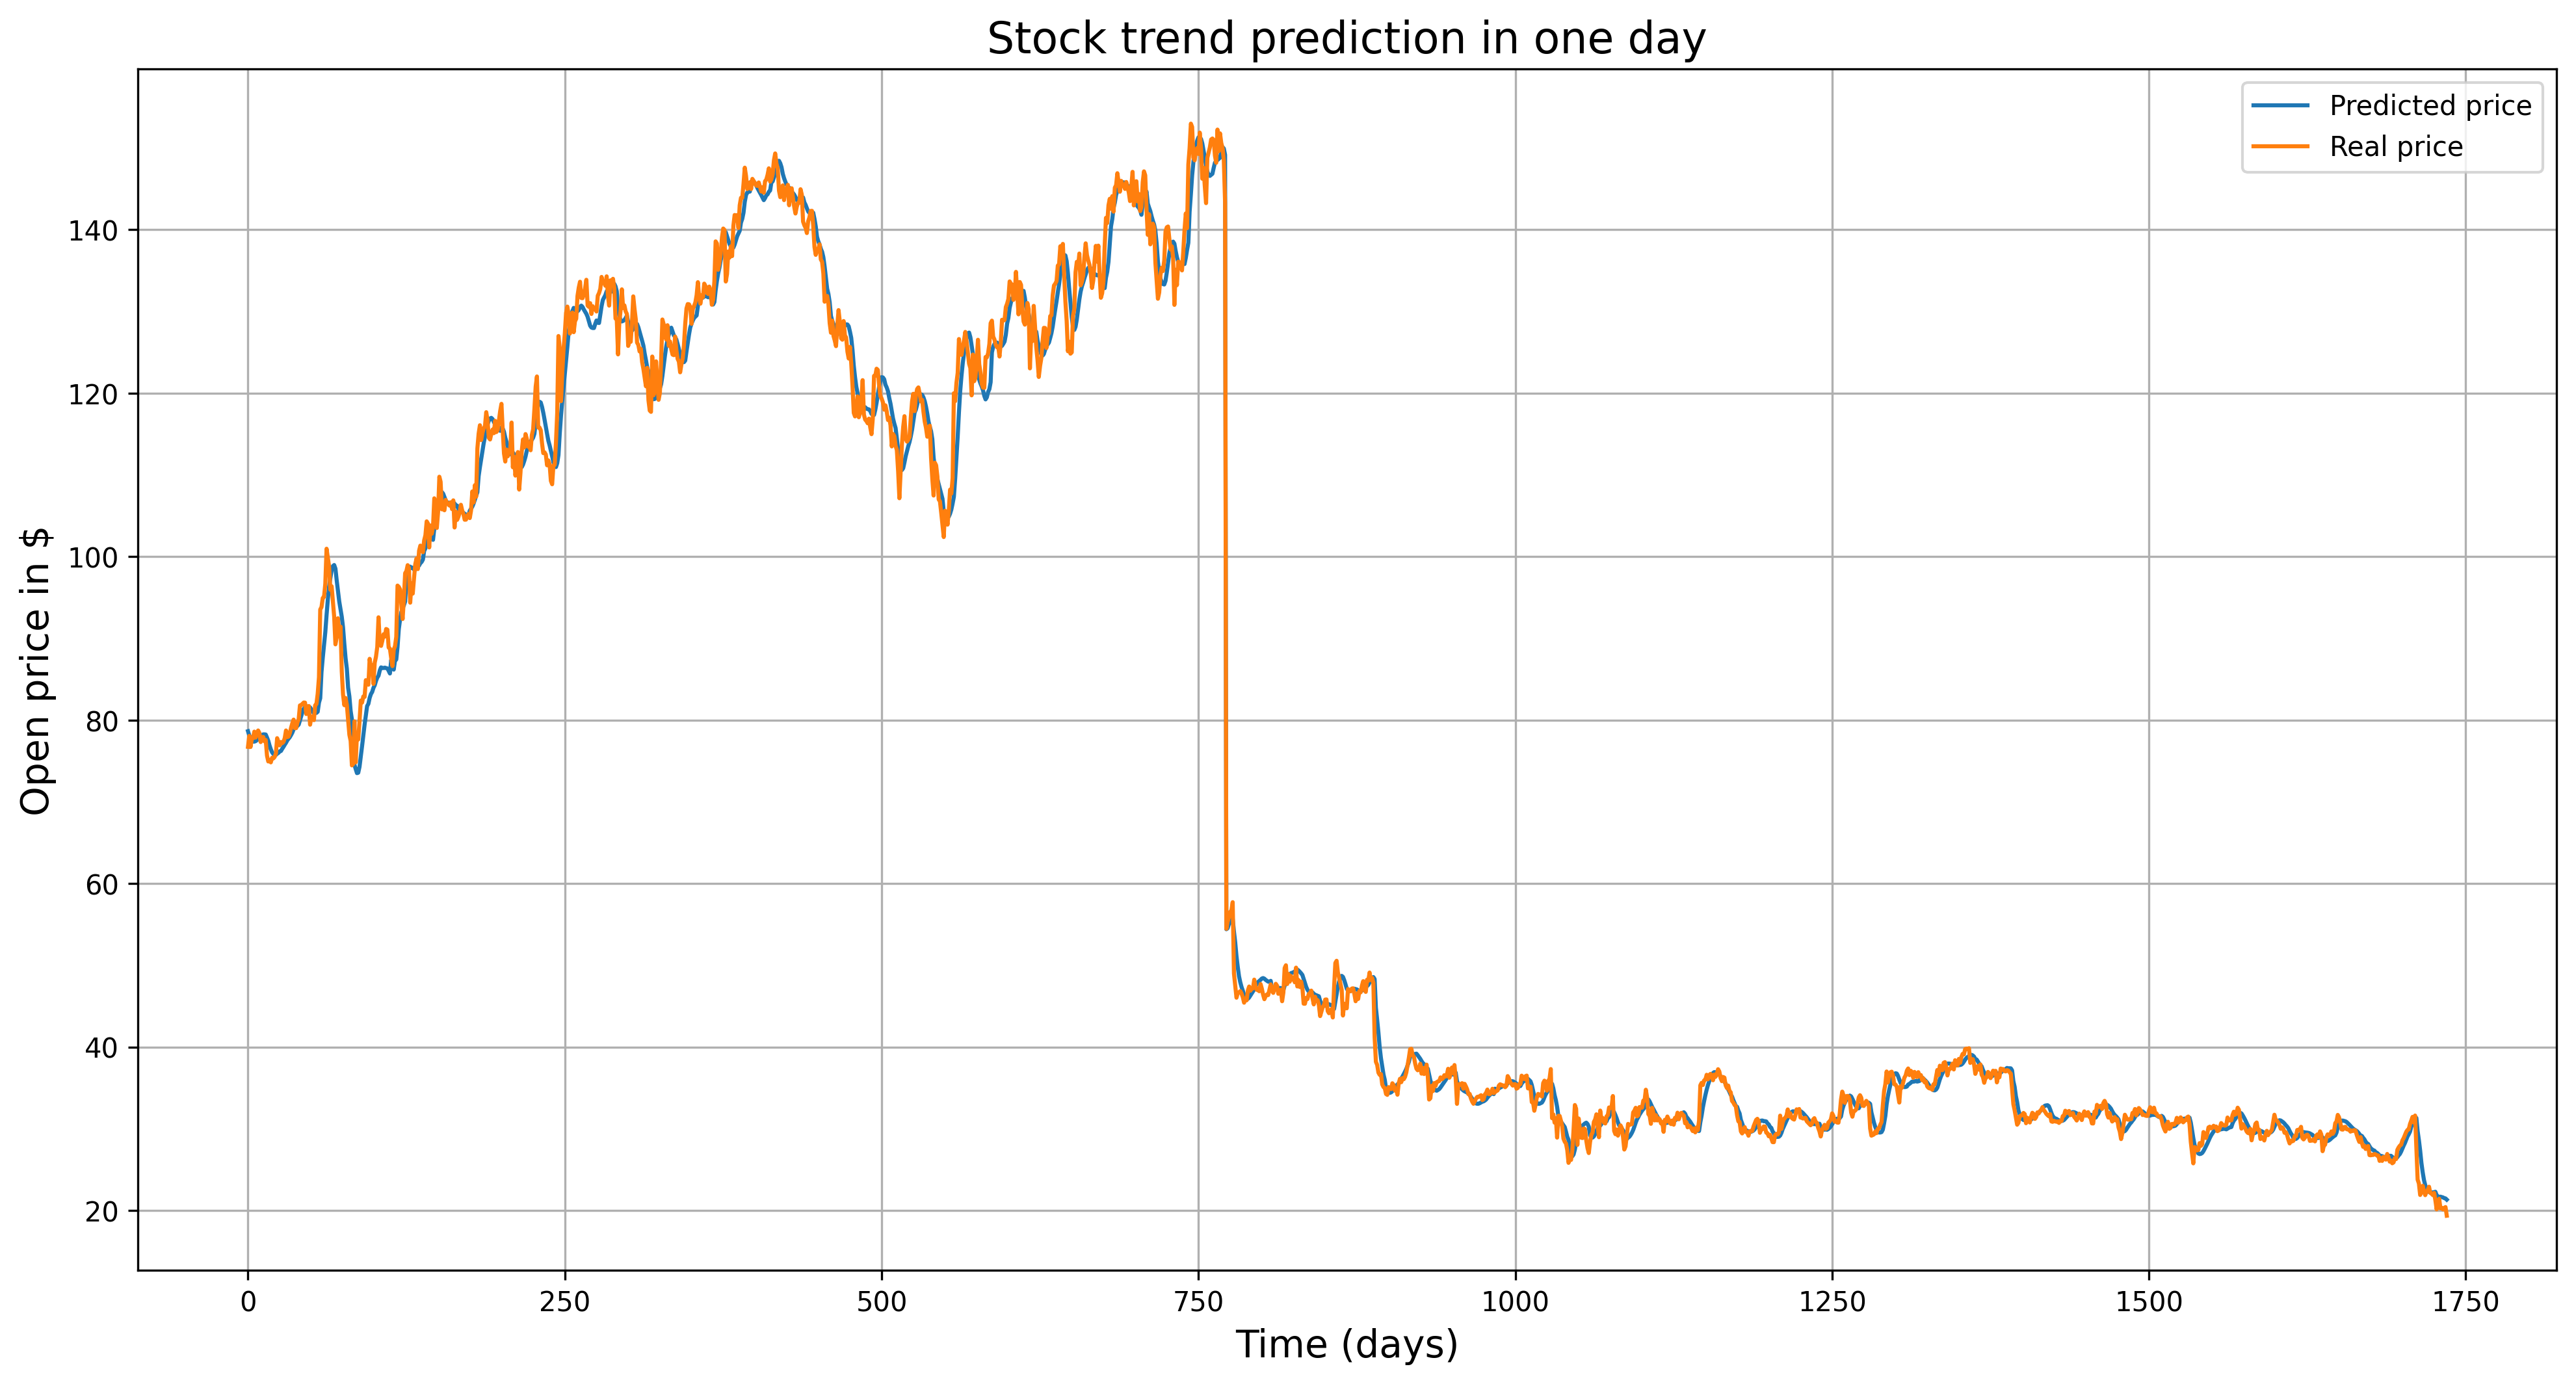

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(x_test[i])
    max_feature = np.max(x_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize predicted stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

### **Third-Day Ahead Open Price Prediction**

#### **Create samples**

In [ ]:
x_data_ccoi_3rd, y_data_ccoi_3rd = create_sample(ccoi, forecast_horizon=3)
x_data_chtr_3rd, y_data_chtr_3rd = create_sample(chtr, forecast_horizon=3)
x_data_cmcsa_3rd, y_data_cmcsa_3rd = create_sample(cmcsa, forecast_horizon=3)
x_data_gsat_3rd, y_data_gsat_3rd = create_sample(gsat, forecast_horizon=3)
x_data_irdm_3rd, y_data_irdm_3rd = create_sample(irdm, forecast_horizon=3)
x_data_lbrda_3rd, y_data_lbrda_3rd = create_sample(lbrda, forecast_horizon=3)
x_data_sats_3rd, y_data_sats_3rd = create_sample(sats, forecast_horizon=3)
x_data_tmus_3rd, y_data_tmus_3rd = create_sample(tmus, forecast_horizon=3)
x_data_usm_3rd, y_data_usm_3rd = create_sample(usm, forecast_horizon=3)

x_data_3rd_all = [x_data_ccoi_3rd, x_data_chtr_3rd, x_data_cmcsa_3rd, x_data_gsat_3rd, x_data_irdm_3rd,
                  x_data_lbrda_3rd, x_data_sats_3rd, x_data_tmus_3rd, x_data_usm_3rd]
y_data_3rd_all = [y_data_ccoi_3rd, y_data_chtr_3rd, y_data_cmcsa_3rd, y_data_gsat_3rd, y_data_irdm_3rd,
                  y_data_lbrda_3rd, y_data_sats_3rd, y_data_tmus_3rd, y_data_usm_3rd]

In [ ]:
x_data_3rd = []
y_data_3rd = []

for i in range (len(x_data_3rd_all)):
  x_data_3rd.extend(x_data_3rd_all[i])
  y_data_3rd.extend(y_data_3rd_all[i])

#### **Training preparation**

In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
x_train_3rd, x_test_3rd, y_train_3rd, y_test_3rd = train_test_split(x_data_3rd, y_data_3rd, test_size=0.2, shuffle=False)
x_train_3rd, x_val_3rd, y_train_3rd, y_val_3rd = train_test_split(x_train_3rd, y_train_3rd, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
x_train_3rd = np.array(x_train_3rd, dtype=np.float32)
x_val_3rd = np.array(x_val_3rd, dtype=np.float32)
x_test_3rd = np.array(x_test_3rd, dtype=np.float32)
y_train_3rd = np.array(y_train_3rd, dtype=np.float32)
y_val_3rd = np.array(y_val_3rd, dtype=np.float32)
y_test_3rd = np.array(y_test_3rd, dtype=np.float32)

# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
x_train_3rd = x_train_3rd.reshape(x_train_3rd.shape[0], window_size, 4)
x_val_3rd = x_val_3rd.reshape(x_val_3rd.shape[0], window_size, 4)
x_test_3rd = x_test_3rd.reshape(x_test_3rd.shape[0], window_size, 4)

# Print shape of the training, validation and test set
print("Shape of training set: ", x_train_3rd.shape)
print("Shape of validation set: ", x_val_3rd.shape)
print("Shape of test set: ", x_test_3rd.shape)

Shape of training set:  (5540, 30, 4)
Shape of validation set:  (1386, 30, 4)
Shape of test set:  (1732, 30, 4)


In [ ]:
# MinMax normalize the training data
x_train_3rd_norm = x_train_3rd.copy()
y_train_3rd_norm = y_train_3rd.copy()

for i in range(0, len(x_train_3rd)):
    min_feature = np.min(x_train_3rd[i])
    max_feature = np.max(x_train_3rd[i])
    x_train_3rd_norm[i] = (x_train_3rd[i] - min_feature) / (max_feature - min_feature)
    y_train_3rd_norm[i] = (y_train_3rd[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data
x_val_3rd_norm = x_val_3rd.copy()
y_val_3rd_norm = y_val_3rd.copy()

for i in range(0, len(x_val_3rd)):
    min_feature = np.min(x_val_3rd[i])
    max_feature = np.max(x_val_3rd[i])
    x_val_3rd_norm[i] = (x_val_3rd[i] - min_feature) / (max_feature - min_feature)
    y_val_3rd_norm[i] = (y_val_3rd[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### **Training**

In [ ]:
# Build the model architecture
lstm_model_1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(window_size,4)), # Output dimension of LSTM layer
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm_model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,313 (552.00 KB)

 Trainable params: 141,313 (552.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model_1.compile(optimizer= tf.keras.optimizers.AdamW(learning_rate=8e-5), loss='mse', metrics=['mse'])
history = lstm_model_1.fit(x_train_3rd_norm, y_train_3rd_norm, validation_data=(x_val_3rd_norm,y_val_3rd_norm),
                         epochs=100, batch_size=1024, callbacks = [early_stopping])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.3640 - mse: 0.3640 - val_loss: 0.2225 - val_mse: 0.2225
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 633ms/step - loss: 0.2788 - mse: 0.2788 - val_loss: 0.1772 - val_mse: 0.1772
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 846ms/step - loss: 0.2191 - mse: 0.2191 - val_loss: 0.1405 - val_mse: 0.1405
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 634ms/step - loss: 0.1735 - mse: 0.1735 - val_loss: 0.1160 - val_mse: 0.1160
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 624ms/step - loss: 0.1309 - mse: 0.1309 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 997ms/step - loss: 0.1109 - mse: 0.1109 - val_loss: 0.1193 - val_mse: 0.1193
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 627ms/step - loss: 0.1126 - mse: 0.1126 - val_loss: 0.1253 - val_mse: 0.1253
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 884ms/step - loss: 0.1084 - mse: 0.1084 - val_loss: 0.1184 - val_mse: 0.1184
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 617ms/step - loss: 0.1062 

In [ ]:
# MinMax normalize the test data
x_test_3rd_norm = x_test_3rd.copy()
y_test_3rd_norm = y_test_3rd.copy()
for i in range(0, len(x_test_3rd)):
    min_feature = np.min(x_test_3rd[i])
    max_feature = np.max(x_test_3rd[i])
    x_test_3rd_norm[i] = (x_test_3rd[i] - min_feature) / (max_feature - min_feature)
    y_test_3rd_norm[i] = (y_test_3rd[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_3rd_norm = lstm_model_1.predict(x_test_3rd_norm)

print("MSE on the test set: ", mean_squared_error(y_pred_3rd_norm, y_test_3rd_norm))

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
MSE on the test set:  0.06567975


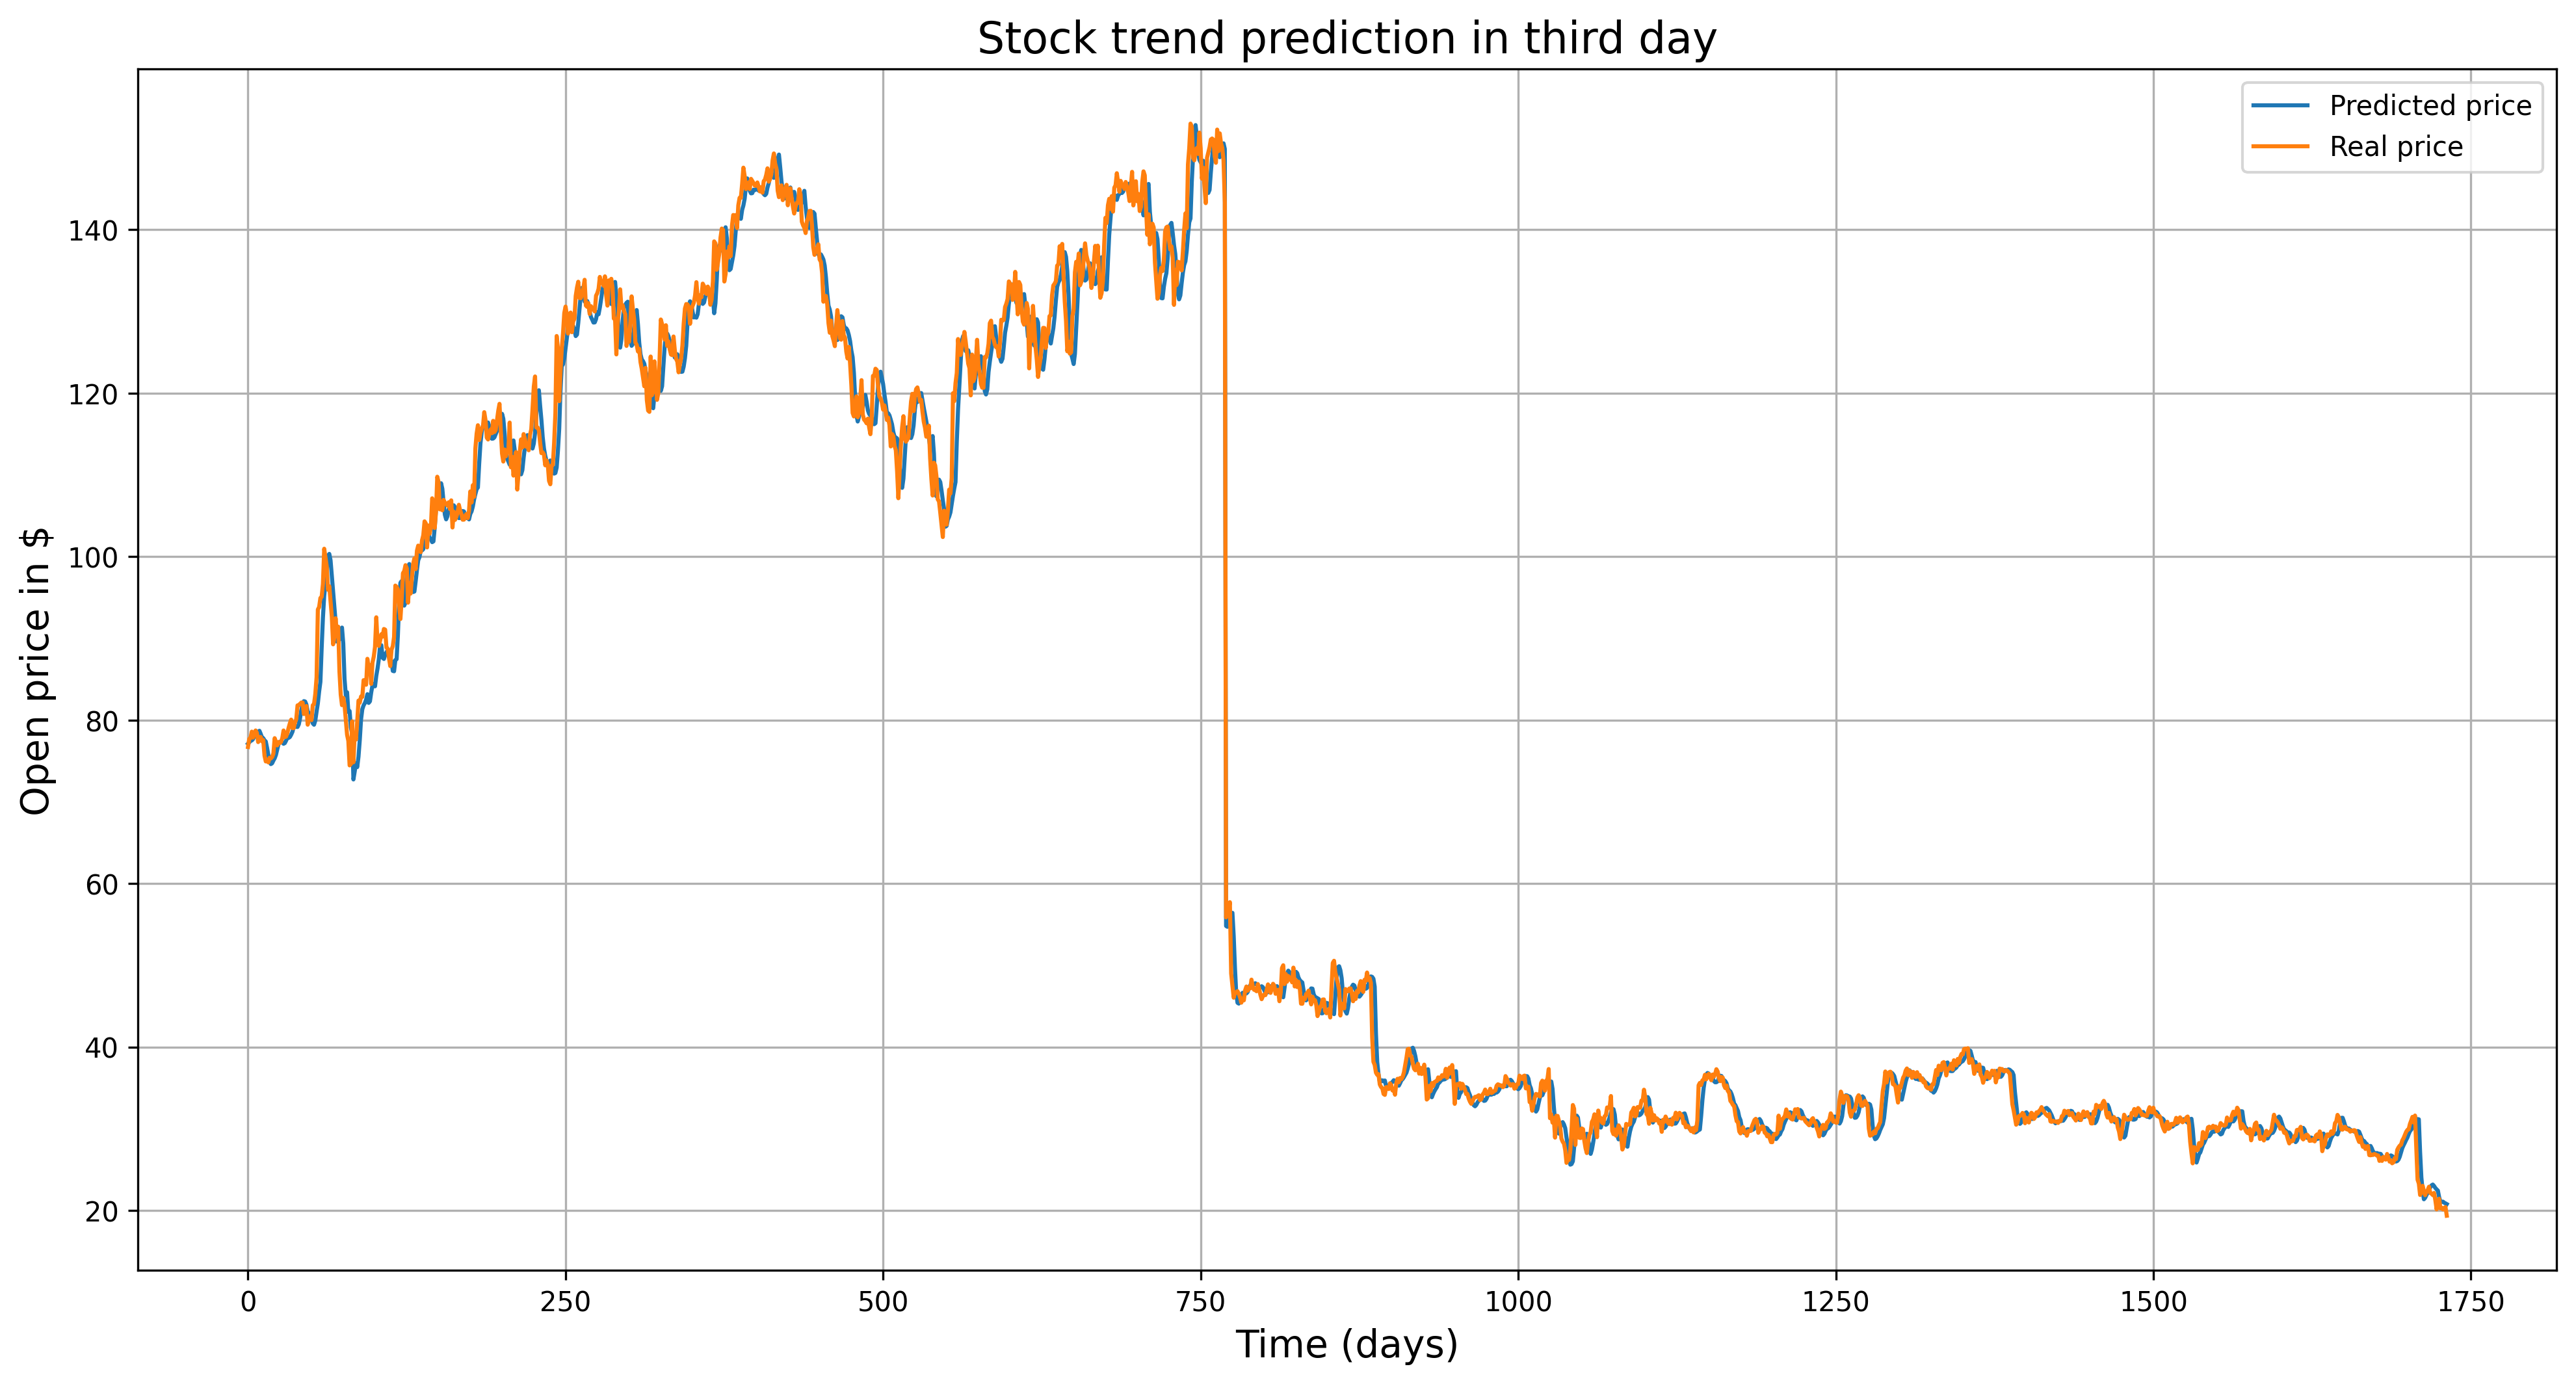

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_3rd_denorm = y_pred_3rd_norm
for i in range(0, len(y_pred_3rd_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(x_test_3rd[i])
    max_feature = np.max(x_test_3rd[i])
    y_pred_3rd_denorm[i] = y_pred_3rd_norm[i] * (max_feature - min_feature) + min_feature

# Visualize predicted stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_3rd_denorm, label='Predicted price')
plt.plot(y_test_3rd, label='Real price')
plt.title('Stock trend prediction in third day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

### **Three-Day Open Price Prediction**

#### **Create samples**

In [ ]:
x_data_ccoi_3, y_data_ccoi_3 = create_sample_multipledays(ccoi, forecast_horizon=3)
x_data_chtr_3, y_data_chtr_3 = create_sample_multipledays(chtr, forecast_horizon=3)
x_data_cmcsa_3, y_data_cmcsa_3 = create_sample_multipledays(cmcsa, forecast_horizon=3)
x_data_gsat_3, y_data_gsat_3 = create_sample_multipledays(gsat, forecast_horizon=3)
x_data_irdm_3, y_data_irdm_3 = create_sample_multipledays(irdm, forecast_horizon=3)
x_data_lbrda_3, y_data_lbrda_3 = create_sample_multipledays(lbrda, forecast_horizon=3)
x_data_sats_3, y_data_sats_3 = create_sample_multipledays(sats, forecast_horizon=3)
x_data_tmus_3, y_data_tmus_3 = create_sample_multipledays(tmus, forecast_horizon=3)
x_data_usm_3, y_data_usm_3 = create_sample_multipledays(usm, forecast_horizon=3)

x_data_3_all = [x_data_ccoi_3, x_data_chtr_3, x_data_cmcsa_3, x_data_gsat_3, x_data_irdm_3,
                x_data_lbrda_3, x_data_sats_3, x_data_tmus_3, x_data_usm_3]
y_data_3_all = [y_data_ccoi_3, y_data_chtr_3, y_data_cmcsa_3, y_data_gsat_3, y_data_irdm_3,
                y_data_lbrda_3, y_data_sats_3, y_data_tmus_3, y_data_usm_3]

In [ ]:
x_data_3 = []
y_data_3 = []

for i in range (len(x_data_3_all)):
  x_data_3.extend(x_data_3_all[i])
  y_data_3.extend(y_data_3_all[i])

#### **Training preparation**

In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_data_3, y_data_3, test_size=0.2, shuffle=False)
x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(x_train_3, y_train_3, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
x_train_3 = np.array(x_train_3, dtype=np.float32)
x_val_3 = np.array(x_val_3, dtype=np.float32)
x_test_3 = np.array(x_test_3, dtype=np.float32)
y_train_3 = np.array(y_train_3, dtype=np.float32)
y_val_3 = np.array(y_val_3, dtype=np.float32)
y_test_3 = np.array(y_test_3, dtype=np.float32)

# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
x_train_3 = x_train_3.reshape(x_train_3.shape[0], window_size, 4)
x_val_3 = x_val_3.reshape(x_val_3.shape[0], window_size, 4)
x_test_3 = x_test_3.reshape(x_test_3.shape[0], window_size, 4)

# Print shape of the training, validation and test set
print("Shape of training set: ", x_train_3.shape)
print("Shape of validation set: ", x_val_3.shape)
print("Shape of test set: ", x_test_3.shape)

Shape of training set:  (5540, 30, 4)
Shape of validation set:  (1386, 30, 4)
Shape of test set:  (1732, 30, 4)


In [ ]:
# MinMax normalize the training data
x_train_3_norm = x_train_3.copy()
y_train_3_norm = y_train_3.copy()

for i in range(0, len(x_train_3)):
    min_feature = np.min(x_train_3[i])
    max_feature = np.max(x_train_3[i])
    x_train_3_norm[i] = (x_train_3[i] - min_feature) / (max_feature - min_feature)
    y_train_3_norm[i] = (y_train_3[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data
x_val_3_norm = x_val_3.copy()
y_val_3_norm = y_val_3.copy()

for i in range(0, len(x_val_3)):
    min_feature = np.min(x_val_3[i])
    max_feature = np.max(x_val_3[i])
    x_val_3_norm[i] = (x_val_3[i] - min_feature) / (max_feature - min_feature)
    y_val_3_norm[i] = (y_val_3[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### **Training**

In [ ]:
# Build the model architecture
lstm_model_2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(window_size,4)), # Output dimension of LSTM layer
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])

lstm_model_2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,275 (524.51 KB)

 Trainable params: 134,275 (524.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model_2.compile(optimizer= tf.keras.optimizers.AdamW(learning_rate=8.5e-5), loss='mse', metrics=['mse'])
history = lstm_model_2.fit(x_train_3_norm, y_train_3_norm, validation_data=(x_val_3_norm,y_val_3_norm),
                         epochs=100, batch_size=1024, callbacks = [early_stopping])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.4293 - mse: 0.4293 - val_loss: 0.3148 - val_mse: 0.3148
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 640ms/step - loss: 0.4027 - mse: 0.4027 - val_loss: 0.2995 - val_mse: 0.2995
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 994ms/step - loss: 0.3784 - mse: 0.3784 - val_loss: 0.2826 - val_mse: 0.2826
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step - loss: 0.3622 - mse: 0.3622 - val_loss: 0.2603 - val_mse: 0.2603
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 995ms/step - loss: 0.3363 - mse: 0.3363 - val_loss: 0.2318 - val_mse: 0.2318
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 645ms/step - loss: 0.2931 - mse: 0.2931 - val_loss: 0.1981 - val_mse: 0.1981
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 865ms/step - loss: 0.2505 - mse: 0.2505 - val_loss: 0.1602 - val_mse: 0.1602
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 673ms/step - loss: 0.1955 - mse: 0.1955 - val_loss: 0.1258 - val_mse: 0.1258
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 686ms/step - loss: 0.1467 

In [ ]:
# MinMax normalize the test data
x_test_3_norm = x_test_3.copy()
y_test_3_norm = y_test_3.copy()
for i in range(0, len(x_test_3)):
    min_feature = np.min(x_test_3[i])
    max_feature = np.max(x_test_3[i])
    x_test_3_norm[i] = (x_test_3[i] - min_feature) / (max_feature - min_feature)
    y_test_3_norm[i] = (y_test_3[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_3_norm = lstm_model_2.predict(x_test_3_norm)

print("MSE on the test set: ", mean_squared_error(y_pred_3_norm, y_test_3_norm))

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MSE on the test set:  0.036901742


In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_3_denorm = y_pred_3_norm
for i in range(0, len(y_pred_3_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(x_test_3[i])
    max_feature = np.max(x_test_3[i])
    y_pred_3_denorm[i] = y_pred_3_norm[i] * (max_feature - min_feature) + min_feature

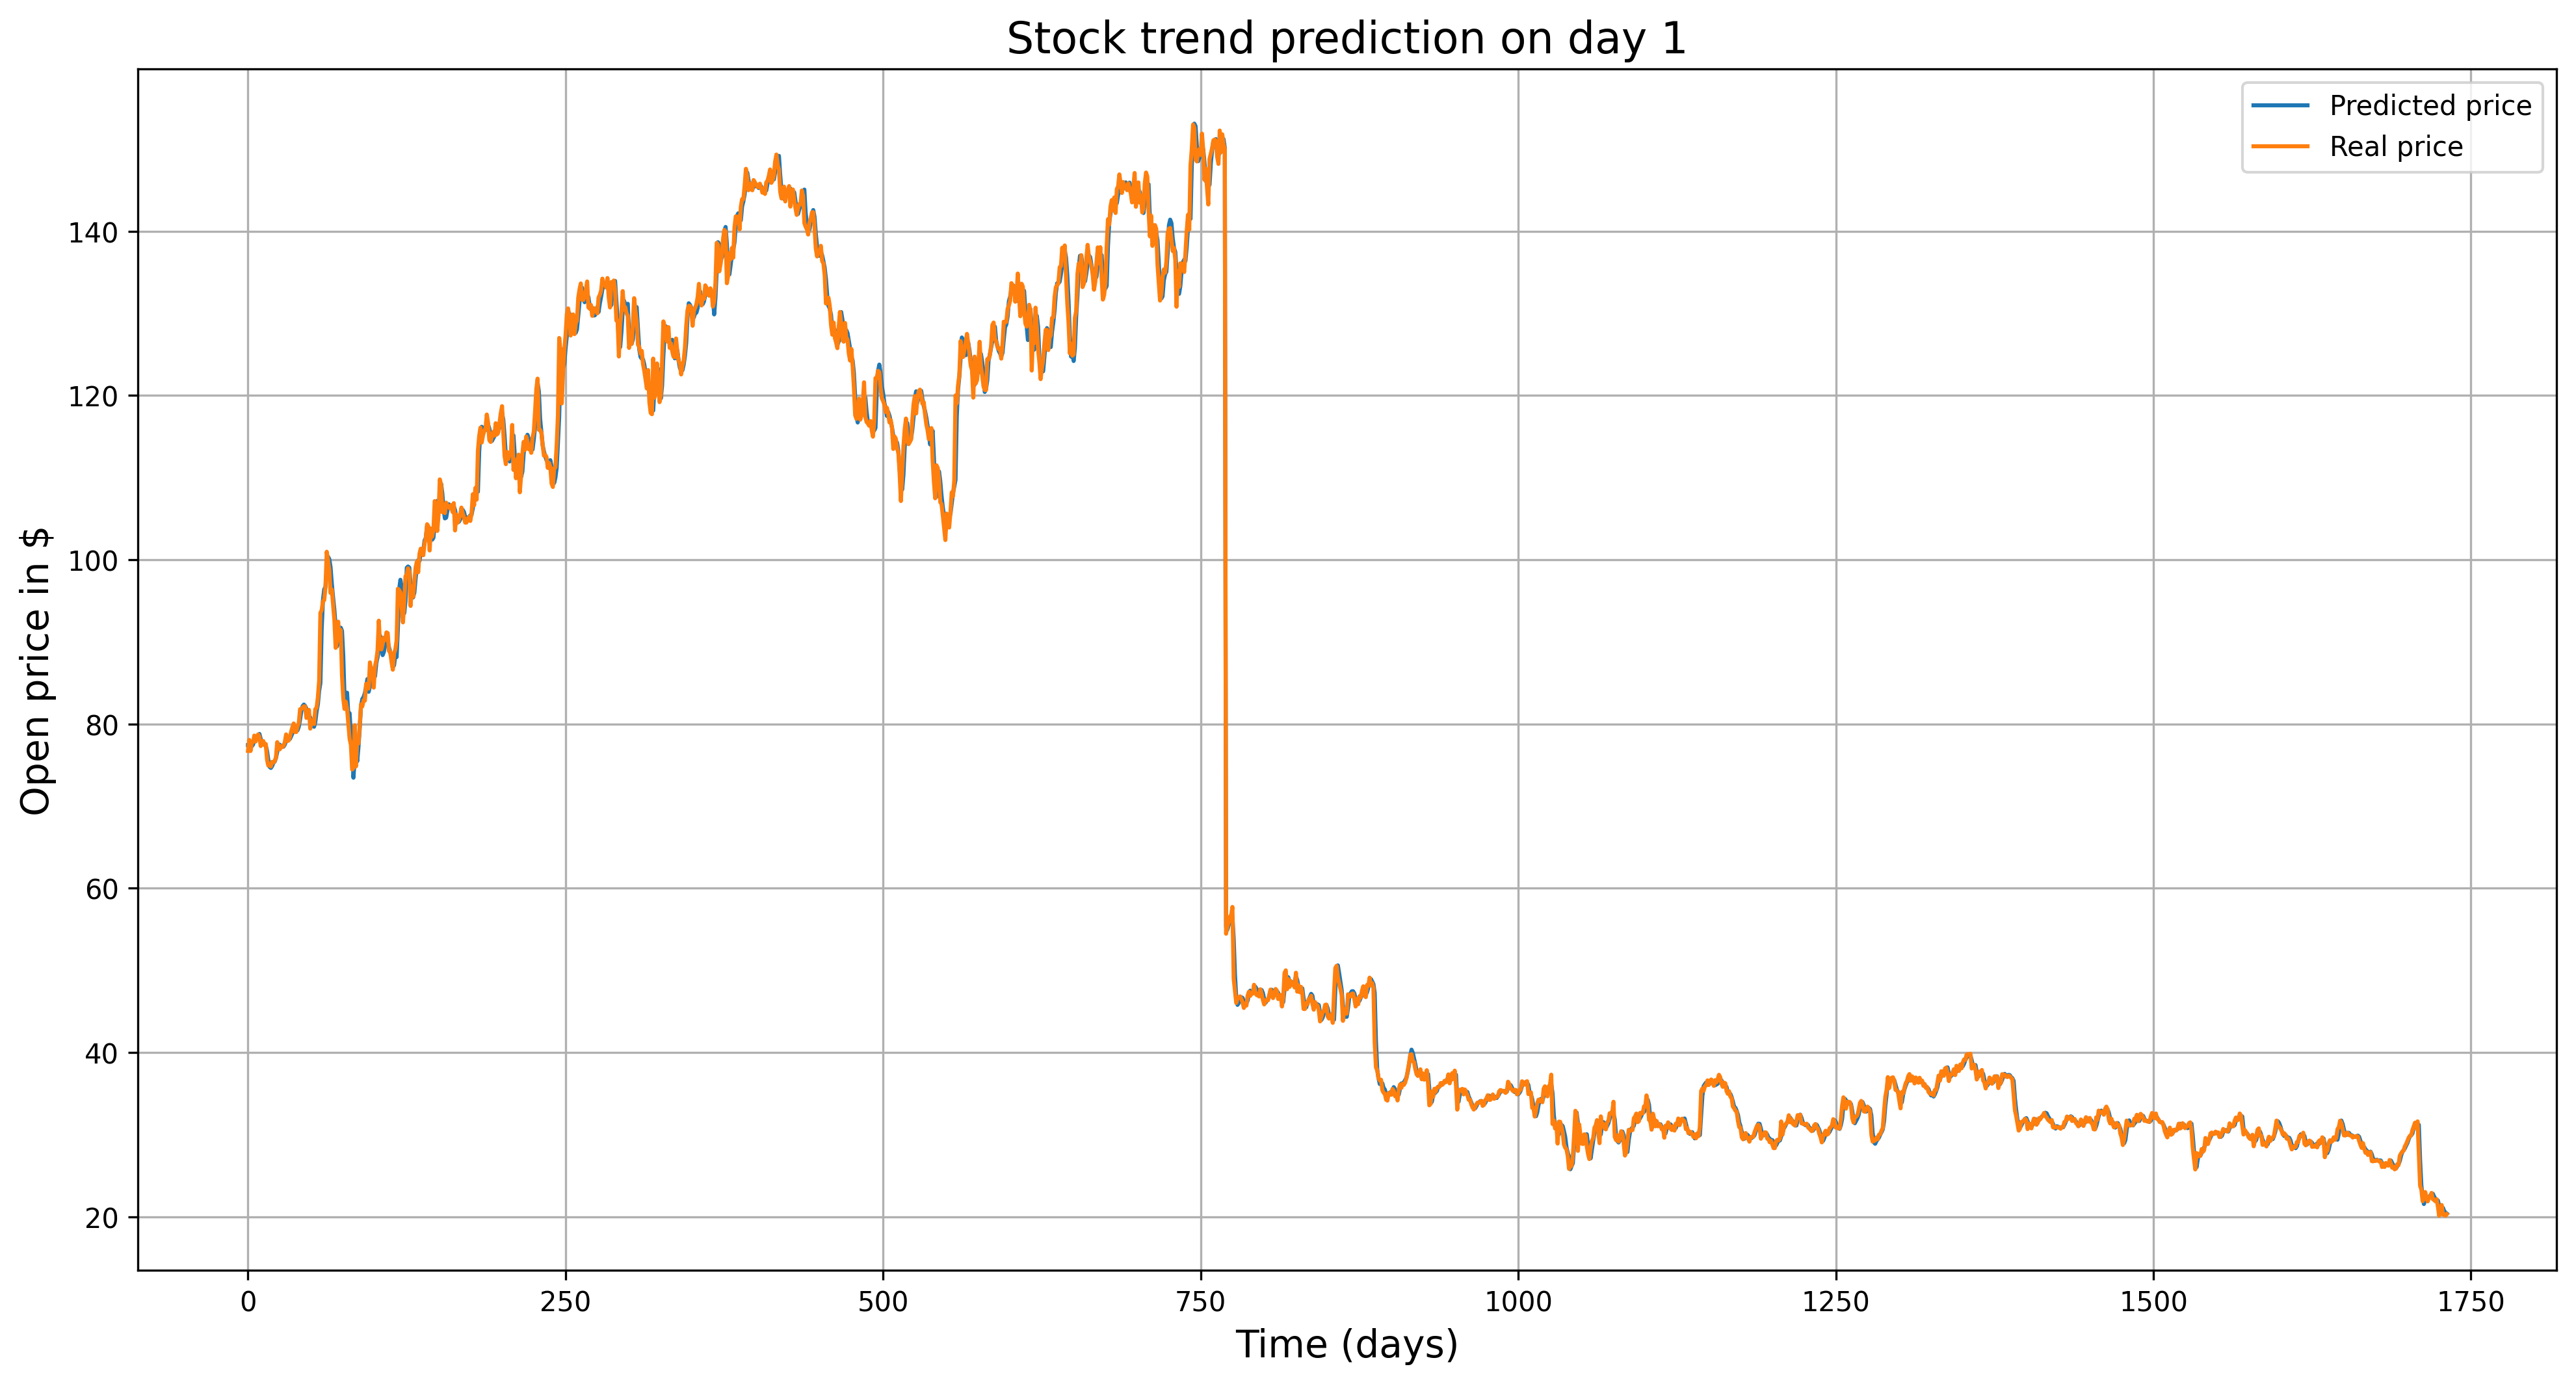

In [ ]:
# Visualize predicted stock price versus real stock price of day 1
plot_mulitple_days(y_pred_3_denorm, y_test_3, 1)

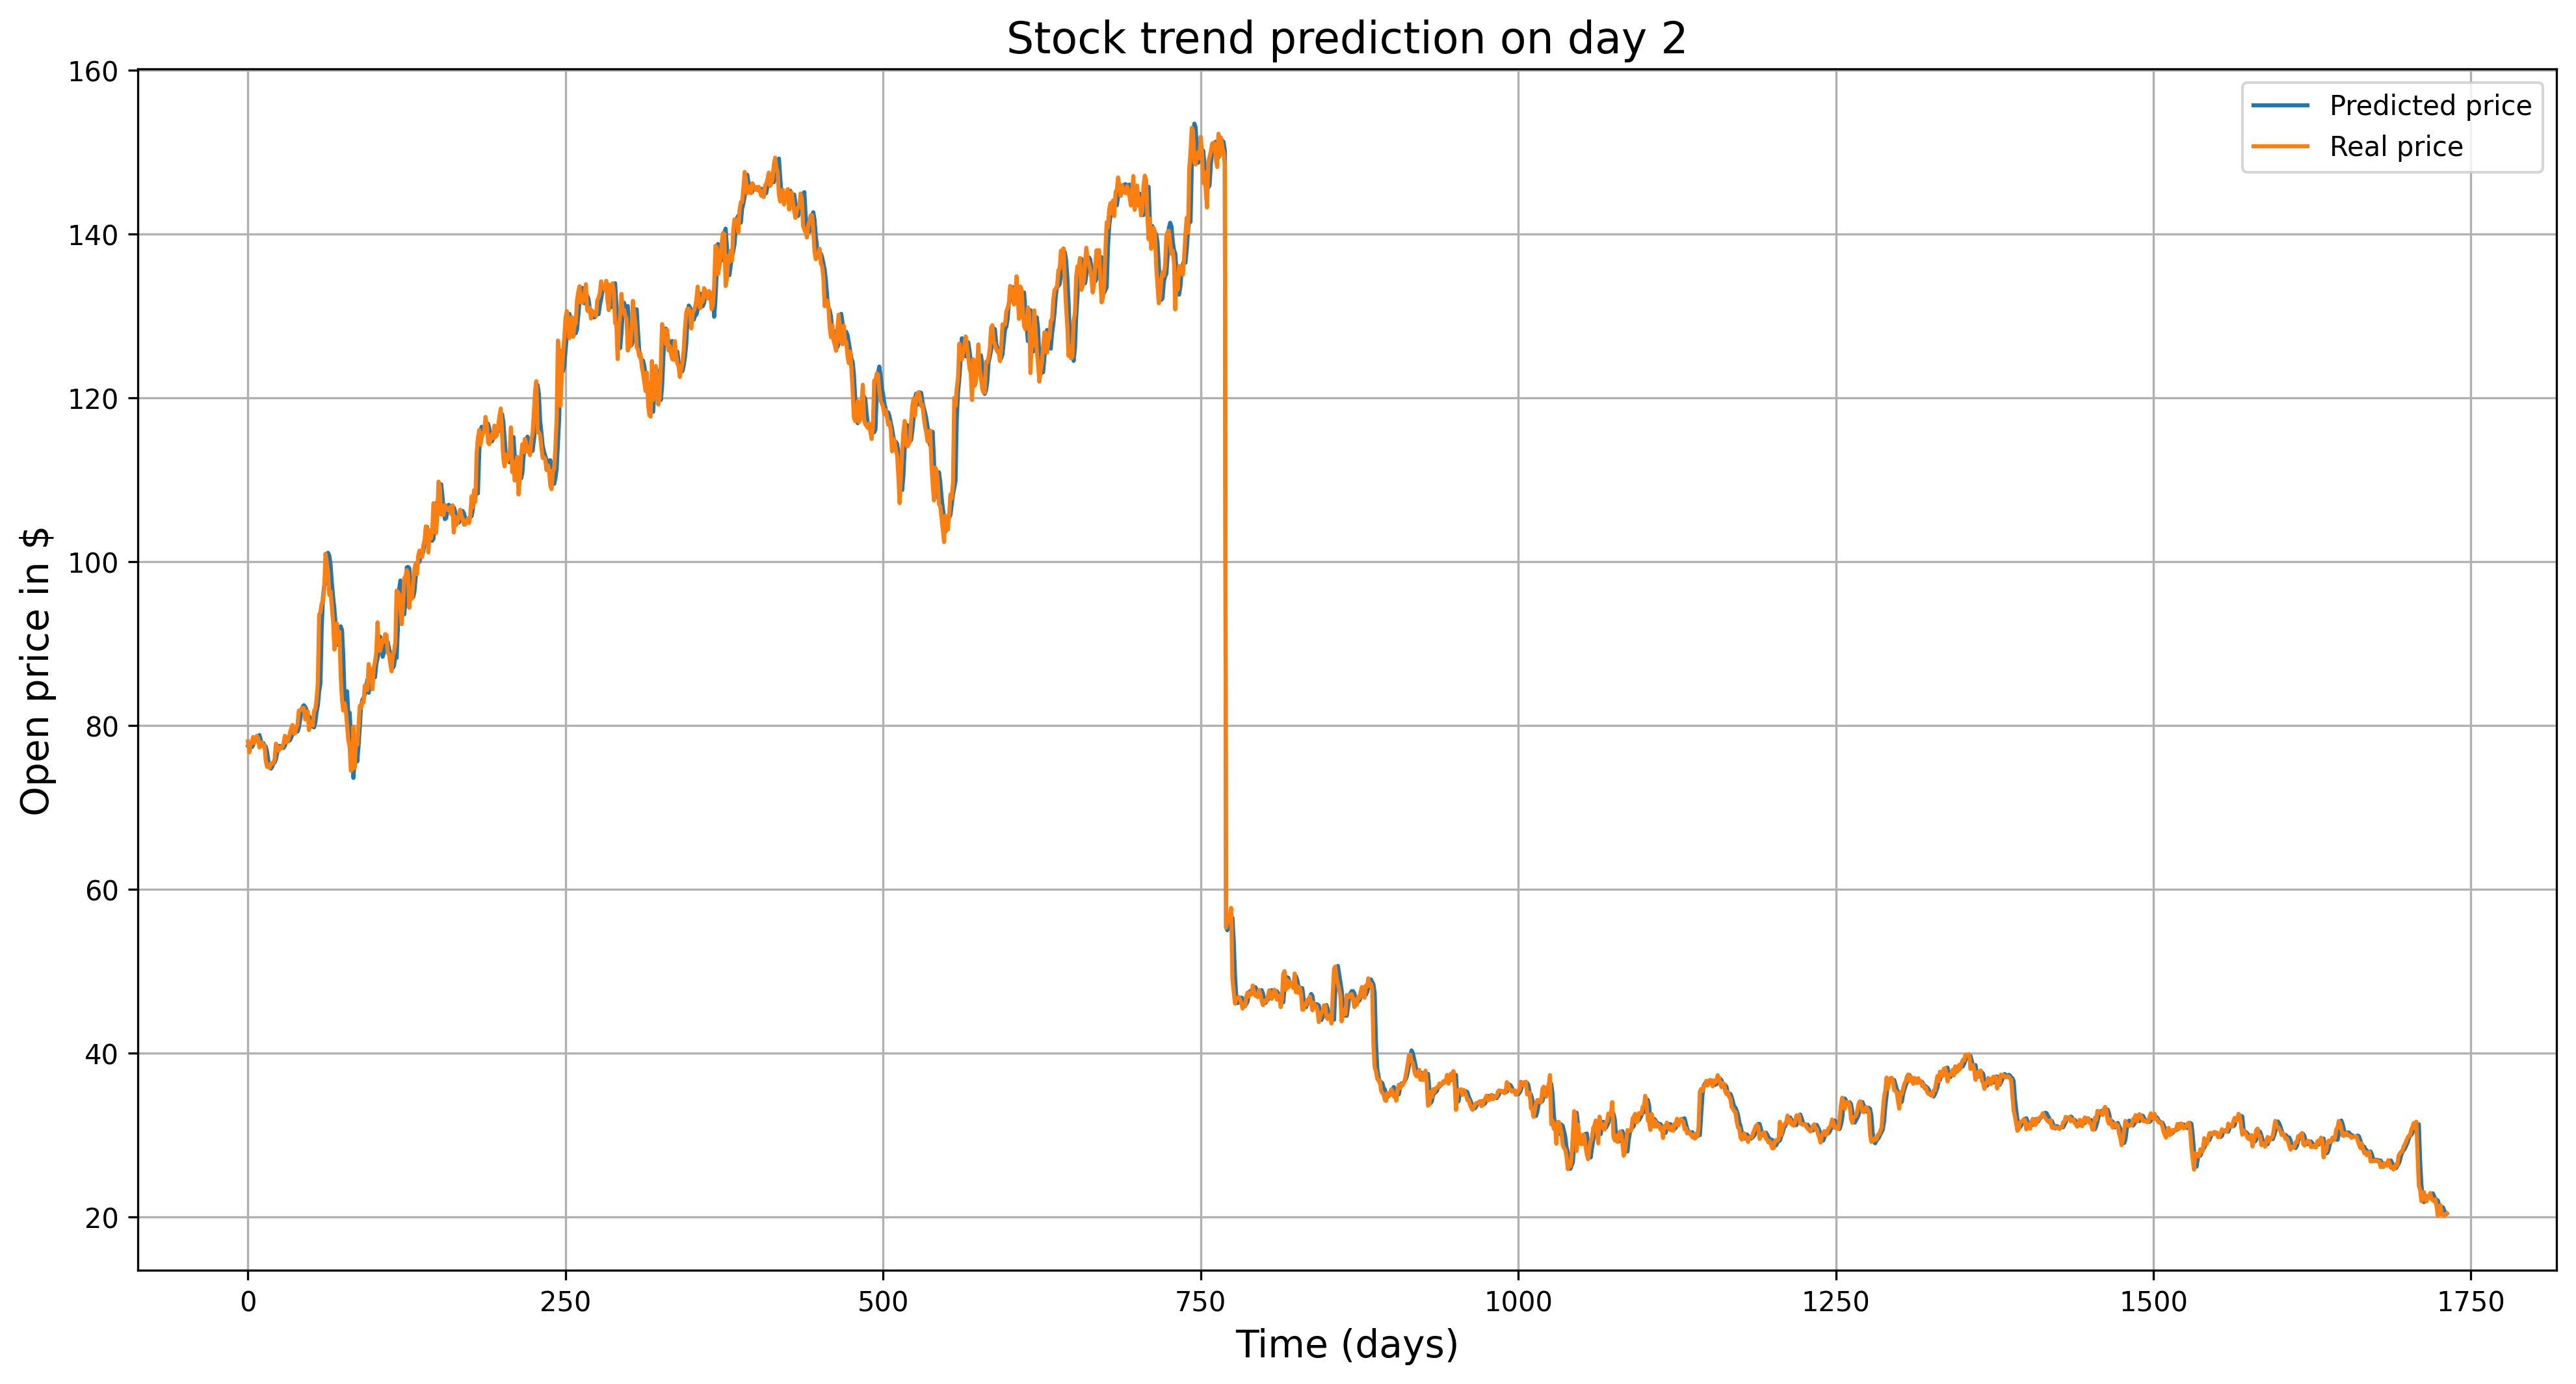

In [ ]:
# Visualize predicted stock price versus real stock price of day 2
plot_mulitple_days(y_pred_3_denorm, y_test_3, 2)

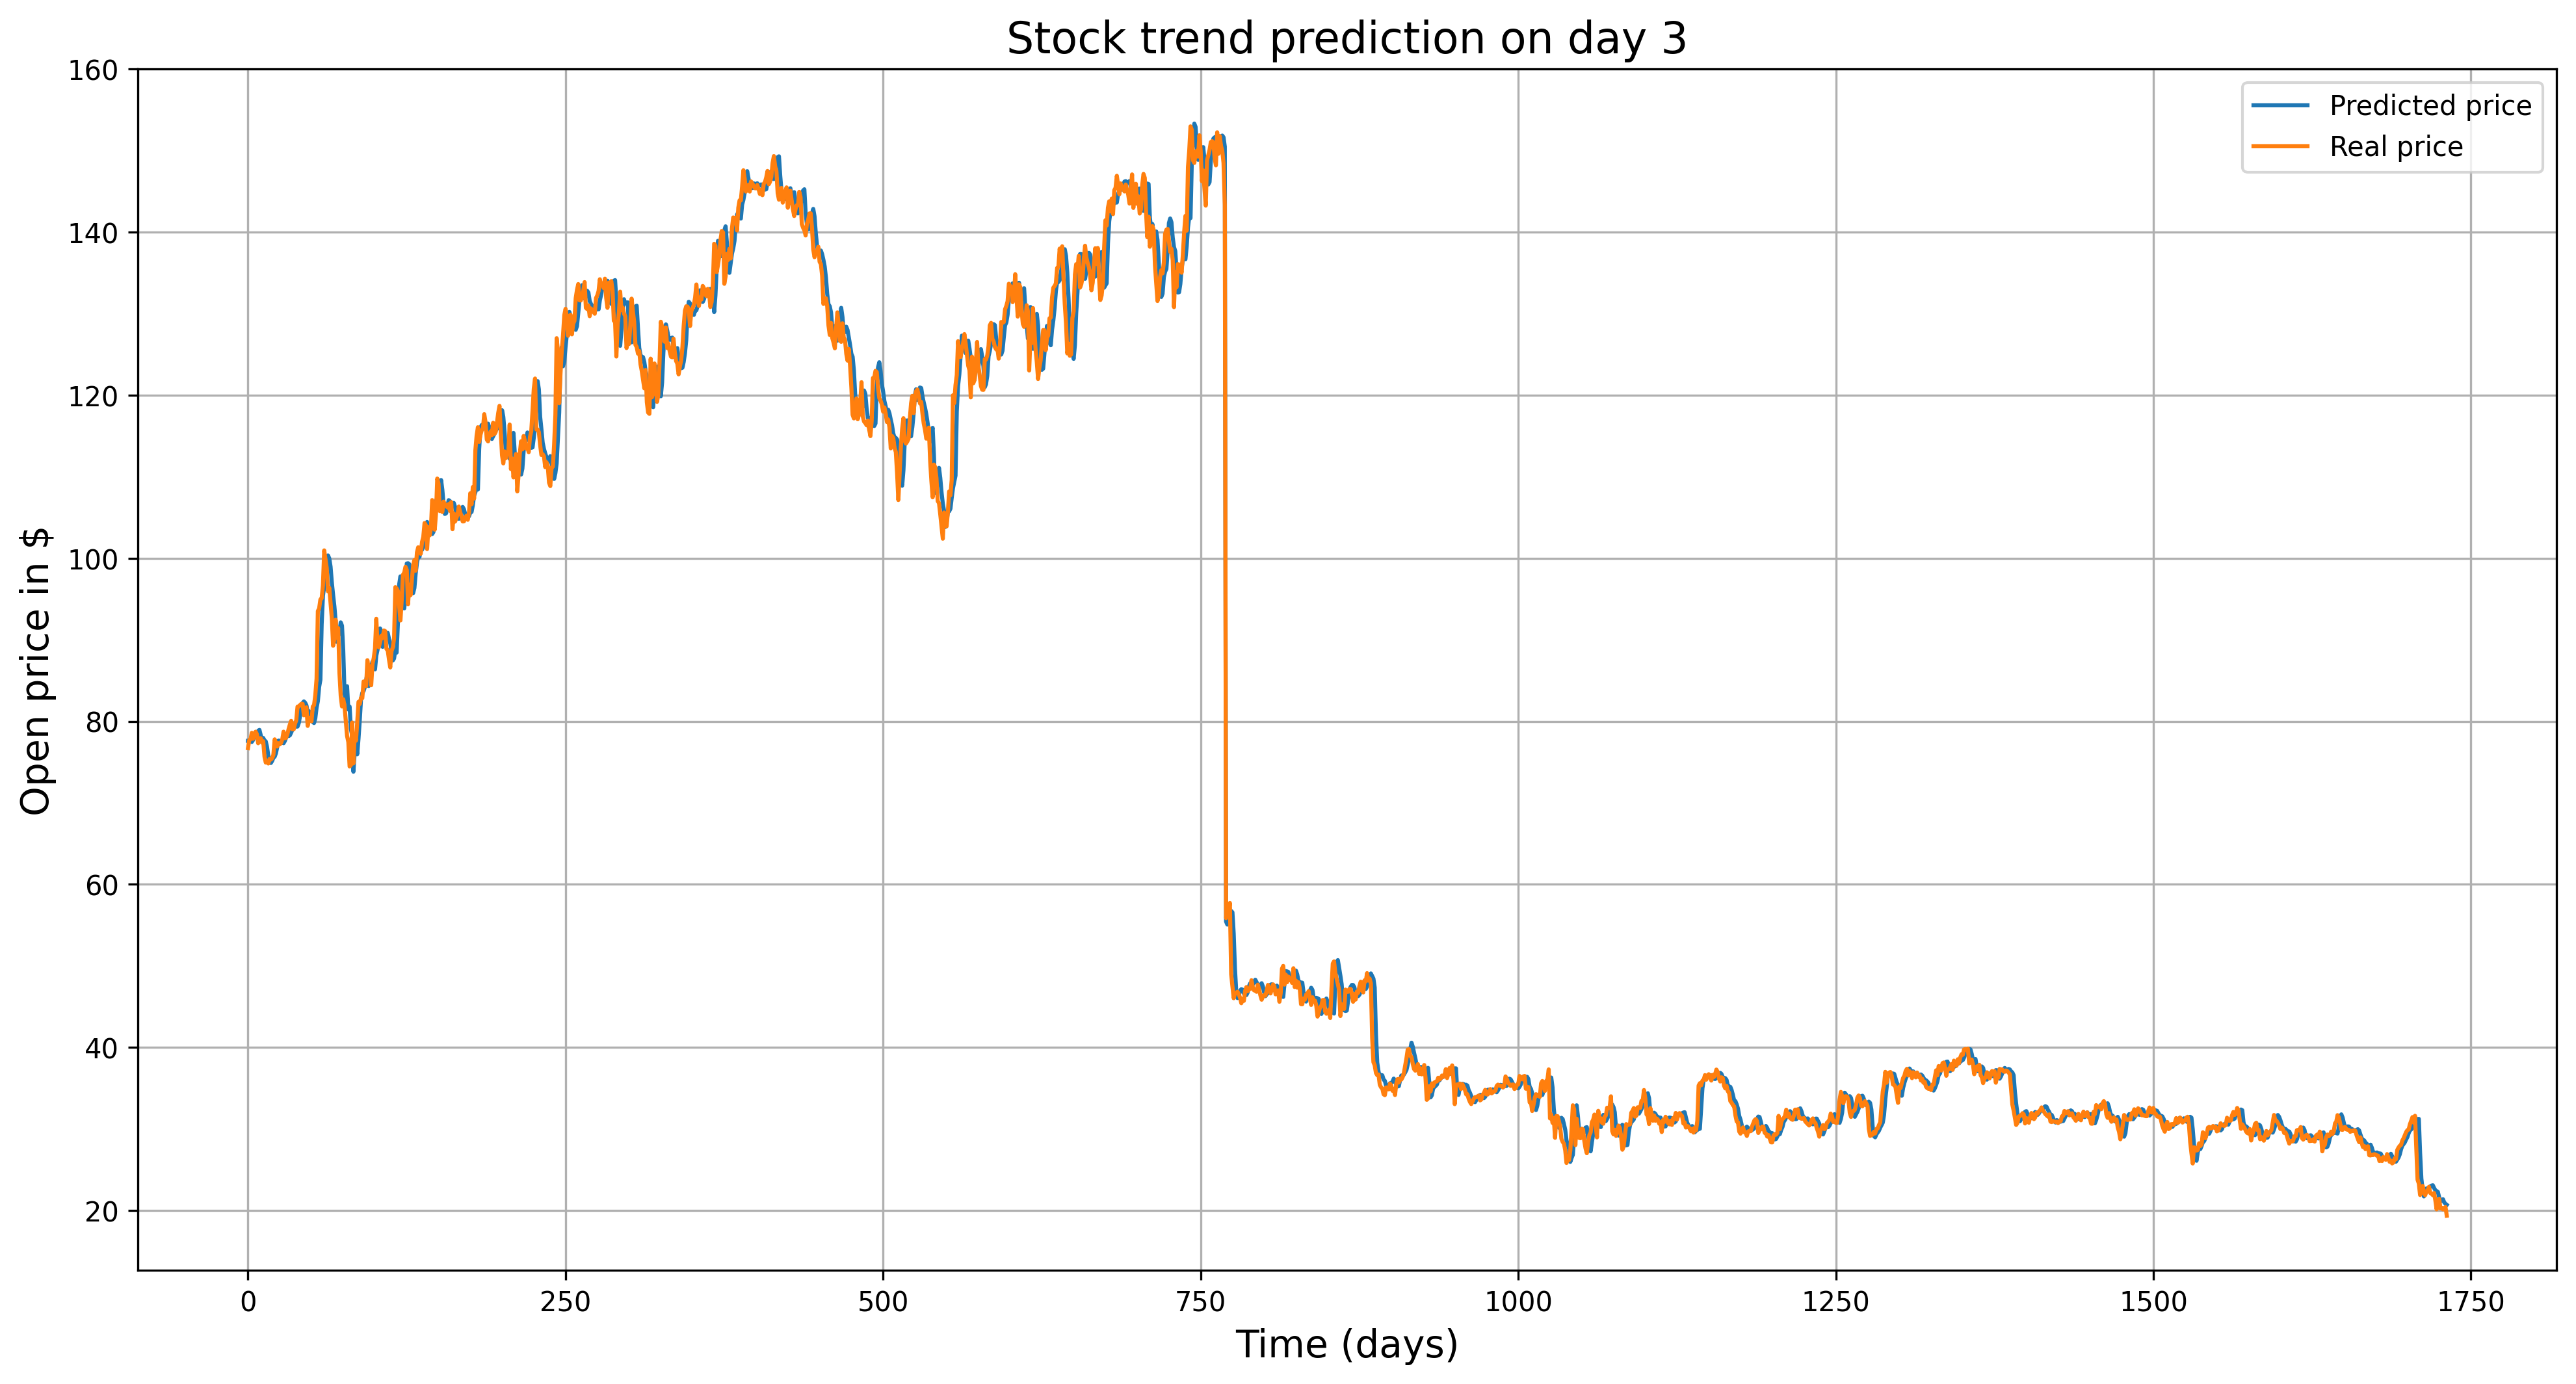

In [ ]:
# Visualize predicted stock price versus real stock price of day 3
plot_mulitple_days(y_pred_3_denorm, y_test_3, 3)

## **Vietnam Stock Open Price Prediction**

In [ ]:
fox = load_data('FOX-UpcomIndex-History', 'data-vn/historical data')
vgi = load_data('VGI-UpcomIndex-History', 'data-vn/historical data')

### **Next-day Open Price Prediction**

#### **Create samples**

In [ ]:
x_data_fox, y_data_fox = create_sample(fox, features=[0, 1, 2, 3], feature_index = 0)
x_data_vgi, y_data_vgi = create_sample(vgi, features=[0, 1, 2, 3], feature_index = 0)

x_data_all = [x_data_vgi, x_data_fox]
y_data_all = [y_data_vgi, y_data_fox]

In [ ]:
x_data = []
y_data = []

for i in range (len(x_data_all)):
  x_data.extend(x_data_all[i])
  y_data.extend(y_data_all[i])

#### **Training preparation**

In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
x_train = np.array(x_train, dtype=np.float32)
x_val = np.array(x_val, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
x_train = x_train.reshape(x_train.shape[0], window_size, 4)
x_val = x_val.reshape(x_val.shape[0], window_size, 4)
x_test = x_test.reshape(x_test.shape[0], window_size, 4)

# Print shape of the training, validation and test set
print("Shape of training set: ", x_train.shape)
print("Shape of validation set: ", x_val.shape)
print("Shape of test set: ", x_test.shape)

Shape of training set:  (1009, 30, 4)
Shape of validation set:  (253, 30, 4)
Shape of test set:  (542, 30, 4)


In [ ]:
# MinMax normalize the training data
x_train_norm = x_train.copy()
y_train_norm = y_train.copy()

for i in range(0, len(x_train)):
    min_feature = np.min(x_train[i])
    max_feature = np.max(x_train[i])
    x_train_norm[i] = (x_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data
x_val_norm = x_val.copy()
y_val_norm = y_val.copy()

for i in range(0, len(x_val)):
    min_feature = np.min(x_val[i])
    max_feature = np.max(x_val[i])
    x_val_norm[i] = (x_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

r_reduced = ReduceLROnPlateau(monitor='val_mse', mode='min', verbose = 0,
                              factor = 0.2, patience = 5, min_lr = 0.000001)

#### **Training**

In [ ]:
# Build the model architecture
lstm_vn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, 4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, dropout = 0.1, return_sequences=True, activation= 'tanh'),
                                  backward_layer = tf.keras.layers.LSTM(units=256, go_backwards=True, dropout = 0.2, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout = 0.2, return_sequences=True, activation= 'tanh'),
                                  backward_layer = tf.keras.layers.LSTM(units=128, go_backwards=True, dropout = 0.3, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm_vn_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_51 (Bidirectional)     │ (None, 30, 512)             │         534,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_52 (Bidirectional)     │ (None, 30, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_155 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,734,785 (6.62 MB)

 Trainable params: 1,734,785 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_vn_model.compile(optimizer= tf.keras.optimizers.AdamW(learning_rate=5e-5), loss='mse', metrics=['mse'])

history = lstm_vn_model.fit(x_train_norm, y_train_norm, validation_data=(x_val_norm,y_val_norm),
                            epochs=150, batch_size=512, callbacks = [early_stopping, r_reduced])

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 750ms/step - loss: 0.3009 - mse: 0.3009 - val_loss: 0.3569 - val_mse: 0.3569 - learning_rate: 5.0000e-05
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2639 - mse: 0.2639 - val_loss: 0.3088 - val_mse: 0.3088 - learning_rate: 5.0000e-05
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2229 - mse: 0.2229 - val_loss: 0.2541 - val_mse: 0.2541 - learning_rate: 5.0000e-05
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1843 - mse: 0.1843 - val_loss: 0.2074 - val_mse: 0.2074 - learning_rate: 5.0000e-05
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1481 - mse: 0.1481 - val_loss: 0.1593 - val_mse: 0.1593 - learning_rate: 5.0000e-05
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1185 - mse: 0.1185 - val_loss: 0.1273 - val_mse: 0.1273 - learning_rate: 5.0000e-05
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0911 - mse: 0.0911 - val_loss: 0.0964 - val_mse: 0.0964 - learning_ra

In [ ]:
# MinMax normalize the test data
x_test_norm = x_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(x_test)):
    min_feature = np.min(x_test[i])
    max_feature = np.max(x_test[i])
    x_test_norm[i] = (x_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = lstm_vn_model.predict(x_test_norm)

print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
MSE on the test set:  0.037258197


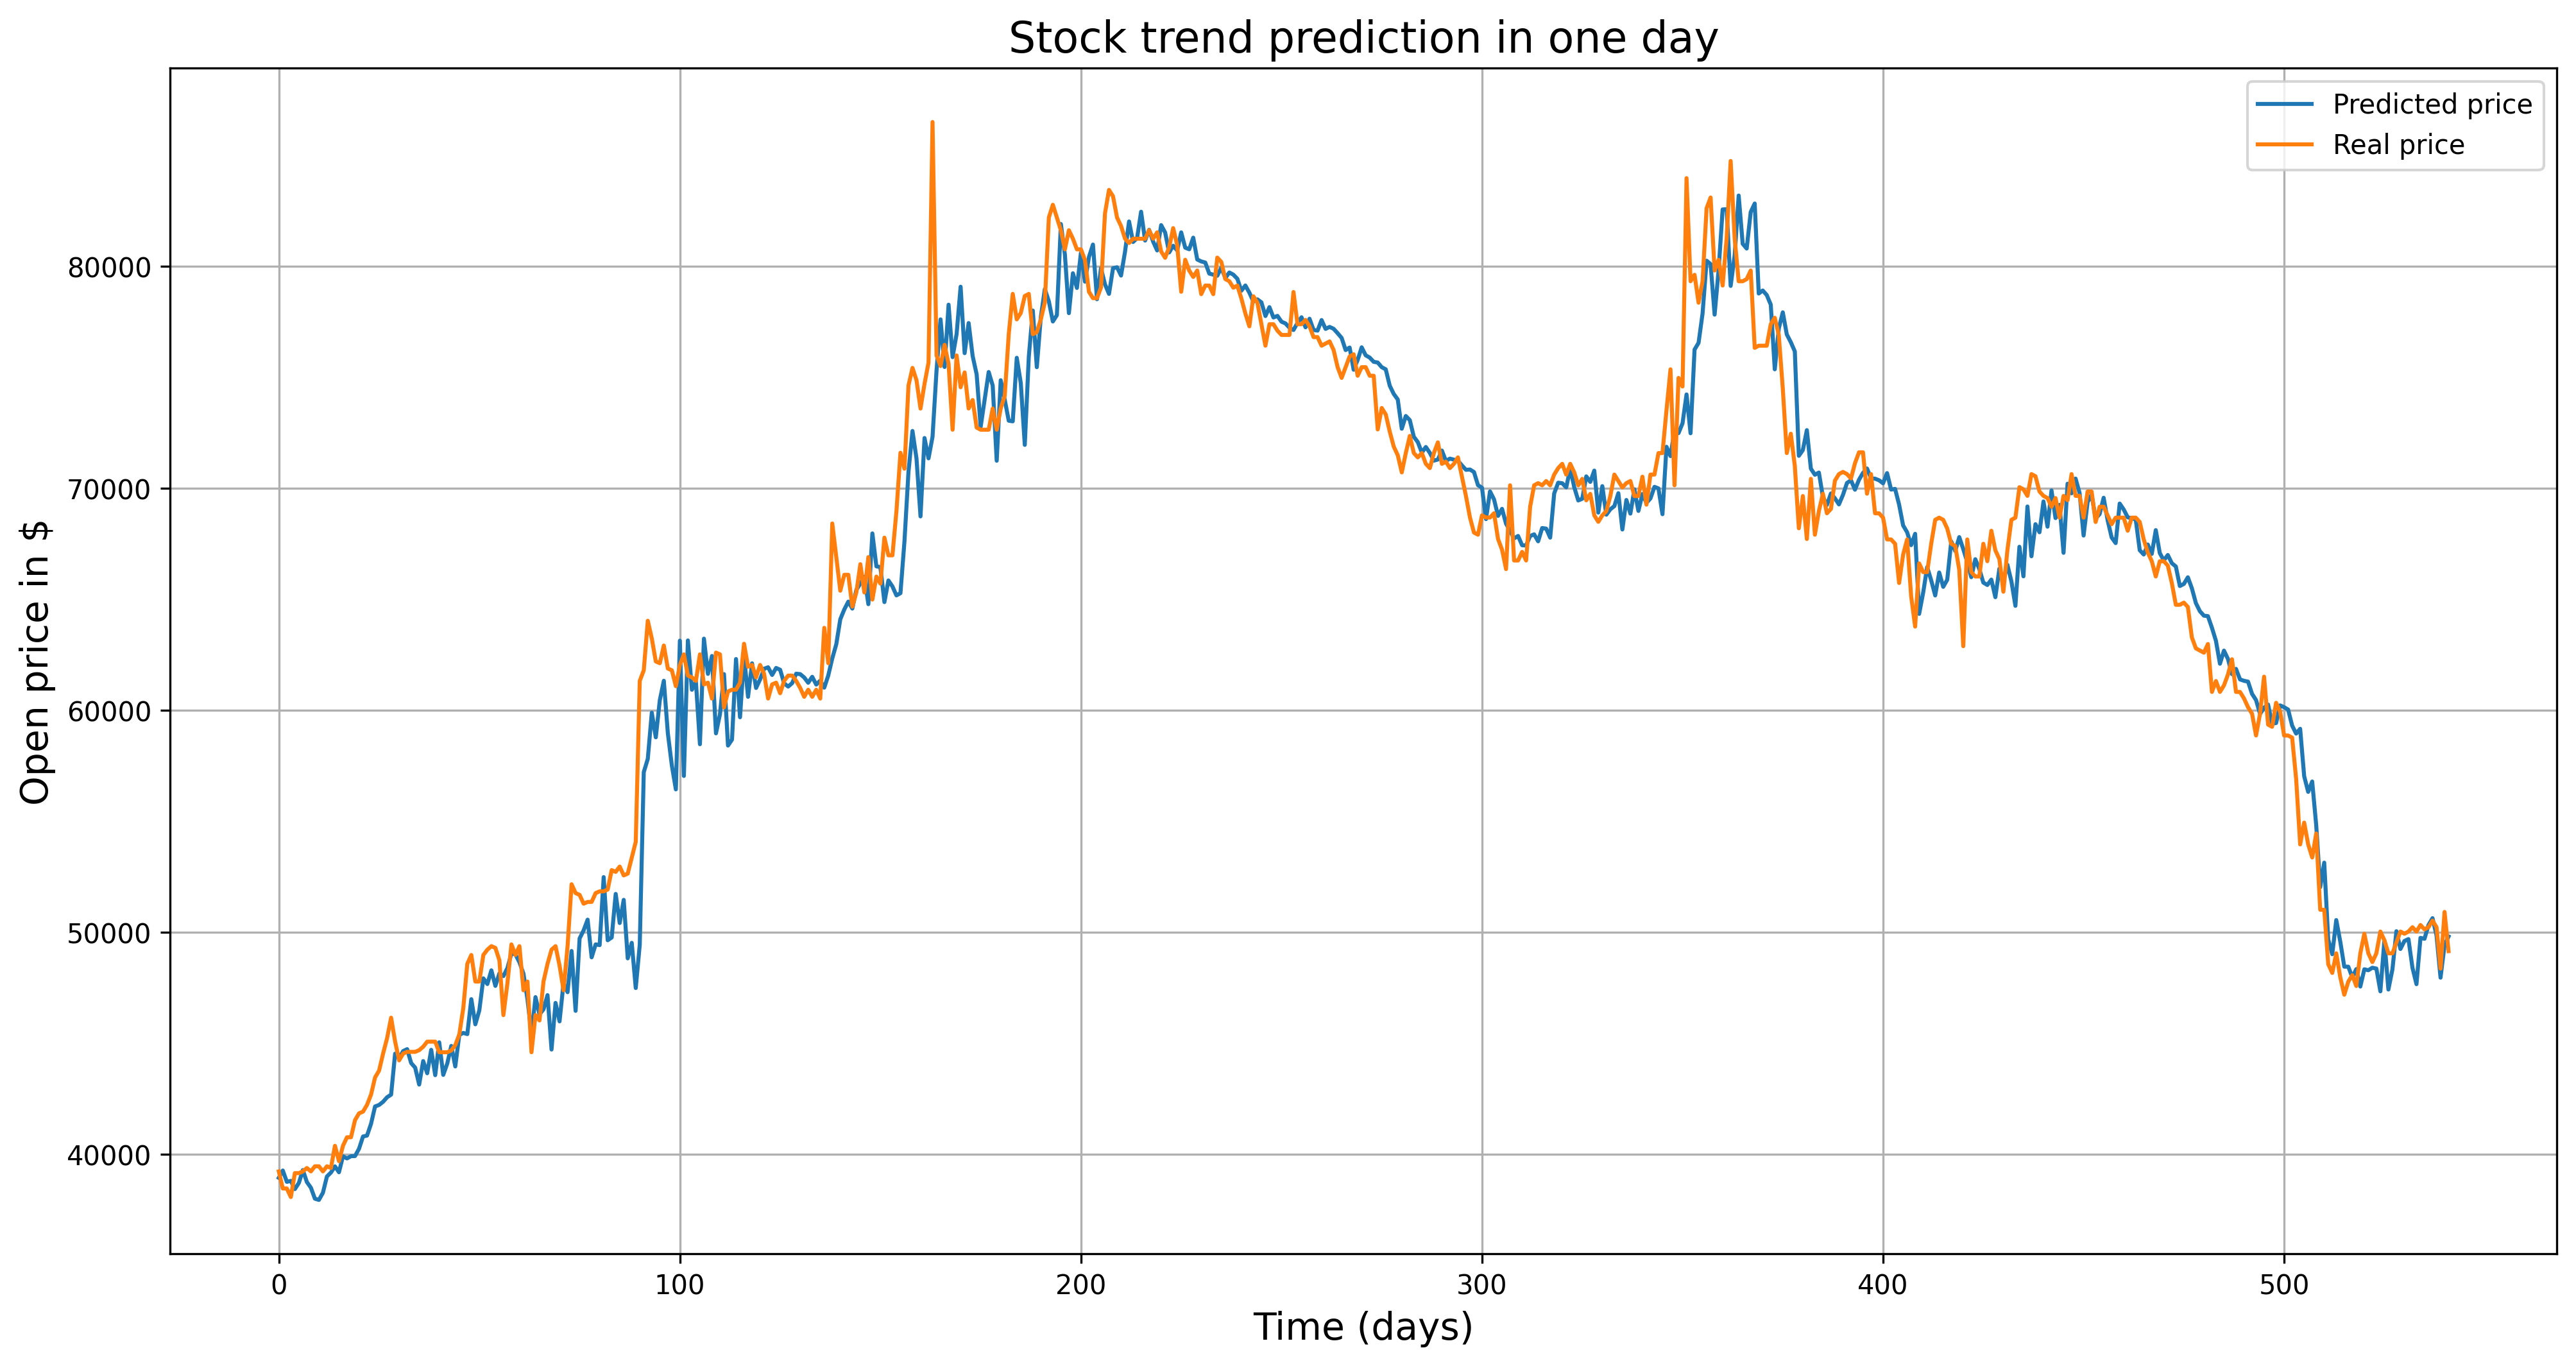

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(x_test[i])
    max_feature = np.max(x_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize predicted stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

### **Seventh-Day Ahead Open Price Prediction**

#### **Create samples**

In [ ]:
x_data_fox_7th, y_data_fox_7th = create_sample(fox, features=[0, 1, 2, 3], feature_index = 0, forecast_horizon = 7)
x_data_vgi_7th, y_data_vgi_7th = create_sample(vgi, features=[0, 1, 2, 3], feature_index = 0, forecast_horizon = 7)

x_data_7th_all = [x_data_vgi_7th, x_data_fox_7th]
y_data_7th_all = [y_data_vgi_7th, y_data_fox_7th]

In [ ]:
x_data_7th = []
y_data_7th = []

for i in range (len(x_data_7th_all)):
  x_data_7th.extend(x_data_7th_all[i])
  y_data_7th.extend(y_data_7th_all[i])

#### **Training preparation**

In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
x_train_7th, x_test_7th, y_train_7th, y_test_7th = train_test_split(x_data_7th, y_data_7th, test_size=0.3, shuffle=False)
x_train_7th, x_val_7th, y_train_7th, y_val_7th = train_test_split(x_train_7th, y_train_7th, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
x_train_7th = np.array(x_train_7th, dtype=np.float32)
x_val_7th = np.array(x_val_7th, dtype=np.float32)
x_test_7th = np.array(x_test_7th, dtype=np.float32)
y_train_7th = np.array(y_train_7th, dtype=np.float32)
y_val_7th = np.array(y_val_7th, dtype=np.float32)
y_test_7th = np.array(y_test_7th, dtype=np.float32)

# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
x_train_7th = x_train_7th.reshape(x_train_7th.shape[0], window_size, 4)
x_val_7th = x_val_7th.reshape(x_val_7th.shape[0], window_size, 4)
x_test_7th = x_test_7th.reshape(x_test_7th.shape[0], window_size, 4)

# Print shape of the training, validation and test set
print("Shape of training set: ", x_train_7th.shape)
print("Shape of validation set: ", x_val_7th.shape)
print("Shape of test set: ", x_test_7th.shape)

Shape of training set:  (1003, 30, 4)
Shape of validation set:  (251, 30, 4)
Shape of test set:  (538, 30, 4)


In [ ]:
# MinMax normalize the training data
x_train_7th_norm = x_train_7th.copy()
y_train_7th_norm = y_train_7th.copy()

for i in range(0, len(x_train_7th)):
    min_feature = np.min(x_train_7th[i])
    max_feature = np.max(x_train_7th[i])
    x_train_7th_norm[i] = (x_train_7th[i] - min_feature) / (max_feature - min_feature)
    y_train_7th_norm[i] = (y_train_7th[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data
x_val_7th_norm = x_val_7th.copy()
y_val_7th_norm = y_val_7th.copy()

for i in range(0, len(x_val_7th)):
    min_feature = np.min(x_val_7th[i])
    max_feature = np.max(x_val_7th[i])
    x_val_7th_norm[i] = (x_val_7th[i] - min_feature) / (max_feature - min_feature)
    y_val_7th_norm[i] = (y_val_7th[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

r_reduced = ReduceLROnPlateau(monitor='val_mse', mode='min', verbose = 0,
                              factor = 0.2, patience = 10, min_lr = 0.000001)

#### **Training**

In [ ]:
# Build the model architecture
lstm_vn_model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, 4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512, dropout = 0.3, return_sequences=True, activation= 'tanh'),
                                  backward_layer = tf.keras.layers.LSTM(units=512, go_backwards=True, dropout = 0.3, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout = 0.2, return_sequences=True, activation= 'tanh'),
                                  backward_layer = tf.keras.layers.LSTM(units=128, go_backwards=True, dropout = 0.3, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout = 0.2, return_sequences=True, activation= 'tanh'),
                                  backward_layer = tf.keras.layers.LSTM(units=128, go_backwards=True, dropout = 0.2, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

lstm_vn_model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 30, 1024)            │       2,117,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 30, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 30, 256)             │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 30, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 30, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,784,385 (18.25 MB)

 Trainable params: 4,784,385 (18.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_vn_model_1.compile(optimizer= tf.keras.optimizers.AdamW(learning_rate=0.2e-3), loss='mse', metrics=['mse'])

history = lstm_vn_model_1.fit(x_train_7th_norm, y_train_7th_norm, validation_data=(x_val_7th_norm, y_val_7th_norm),
                              epochs=150, batch_size=512, callbacks = [early_stopping, r_reduced])

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.4124 - mse: 0.4124 - val_loss: 0.4361 - val_mse: 0.4361 - learning_rate: 2.0000e-04
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.3276 - mse: 0.3276 - val_loss: 0.2259 - val_mse: 0.2259 - learning_rate: 2.0000e-04
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.2028 - mse: 0.2028 - val_loss: 0.1533 - val_mse: 0.1533 - learning_rate: 2.0000e-04
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.2299 - mse: 0.2299 - val_loss: 0.1384 - val_mse: 0.1384 - learning_rate: 2.0000e-04
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.1799 - mse: 0.1799 - val_loss: 0.1966 - val_mse: 0.1966 - learning_rate: 2.0000e-04
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.1829 - mse: 0.1829 - val_loss: 0.2026 - val_mse: 0.2026 - learning_rate: 2.0000e-04
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.1889 - mse: 0.1889 - val_loss: 0.1679 - val_mse: 0.1679 - learning_rate:

In [ ]:
# MinMax normalize the test data
x_test_7th_norm = x_test_7th.copy()
y_test_7th_norm = y_test_7th.copy()
for i in range(0, len(x_test_7th)):
    min_feature = np.min(x_test_7th[i])
    max_feature = np.max(x_test_7th[i])
    x_test_7th_norm[i] = (x_test_7th[i] - min_feature) / (max_feature - min_feature)
    y_test_7th_norm[i] = (y_test_7th[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_7th_norm = lstm_vn_model_1.predict(x_test_7th_norm)

print("MSE on the test set: ", mean_squared_error(y_pred_7th_norm, y_test_7th_norm))

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
MSE on the test set:  0.1380079


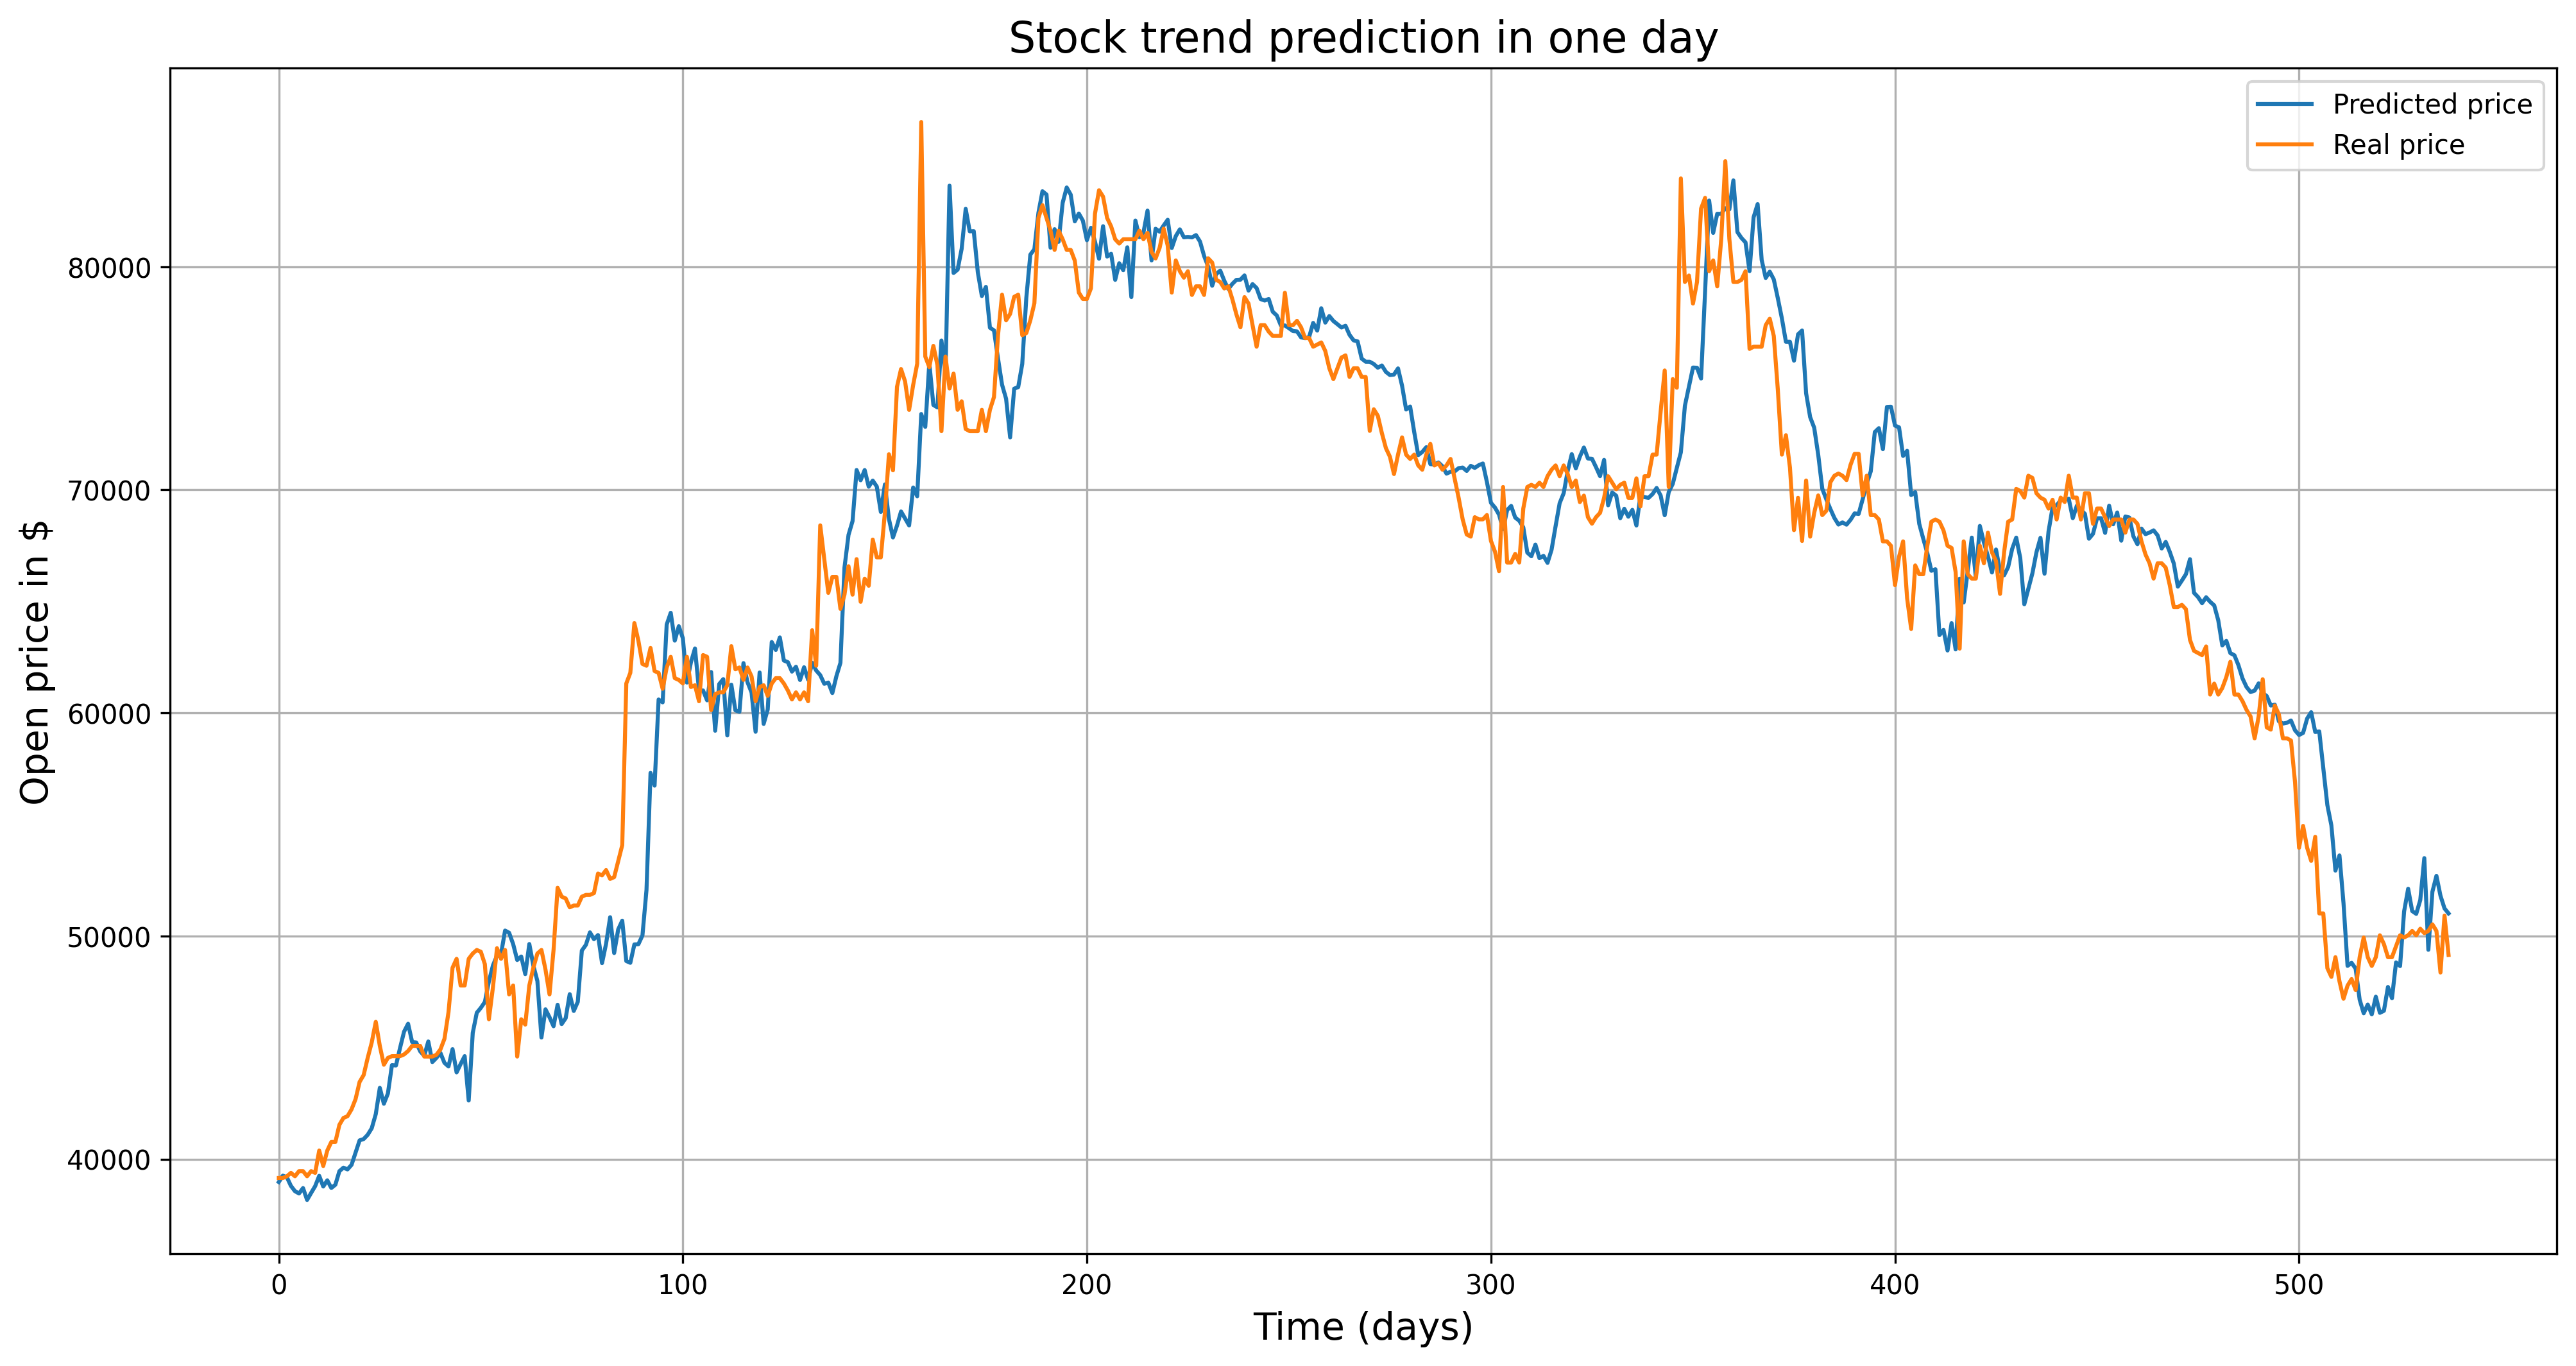

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_7th_denorm = y_pred_7th_norm
for i in range(0, len(y_pred_7th_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(x_test_7th[i])
    max_feature = np.max(x_test_7th[i])
    y_pred_7th_denorm[i] = y_pred_7th_norm[i] * (max_feature - min_feature) + min_feature

# Visualize predicted stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_7th_denorm, label='Predicted price')
plt.plot(y_test_7th, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

### **Seven-Day Open Price Prediction**

#### **Create samples**

In [ ]:
x_data_fox_7, y_data_fox_7 = create_sample_multipledays(fox, features=[0, 1, 2, 3], feature_index = 0, forecast_horizon = 7)
x_data_vgi_7, y_data_vgi_7 = create_sample_multipledays(vgi, features=[0, 1, 2, 3], feature_index = 0, forecast_horizon = 7)

x_data_7_all = [x_data_vgi_7, x_data_fox_7]
y_data_7_all = [y_data_vgi_7, y_data_fox_7]

In [ ]:
x_data_7 = []
y_data_7 = []

for i in range (len(x_data_7_all)):
  x_data_7.extend(x_data_7_all[i])
  y_data_7.extend(y_data_7_all[i])

#### **Training preparation**

In [ ]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(x_data_7, y_data_7, test_size=0.3, shuffle=False)
x_train_7, x_val_7, y_train_7, y_val_7 = train_test_split(x_train_7, y_train_7, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
x_train_7 = np.array(x_train_7, dtype=np.float32)
x_val_7 = np.array(x_val_7, dtype=np.float32)
x_test_7 = np.array(x_test_7, dtype=np.float32)
y_train_7 = np.array(y_train_7, dtype=np.float32)
y_val_7 = np.array(y_val_7, dtype=np.float32)
y_test_7 = np.array(y_test_7, dtype=np.float32)

# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
x_train_7 = x_train_7.reshape(x_train_7.shape[0], window_size, 4)
x_val_7 = x_val_7.reshape(x_val_7.shape[0], window_size, 4)
x_test_7 = x_test_7.reshape(x_test_7.shape[0], window_size, 4)

# Print shape of the training, validation and test set
print("Shape of training set: ", x_train_7.shape)
print("Shape of validation set: ", x_val_7.shape)
print("Shape of test set: ", x_test_7.shape)

Shape of training set:  (1003, 30, 4)
Shape of validation set:  (251, 30, 4)
Shape of test set:  (538, 30, 4)


In [ ]:
# MinMax normalize the training data
x_train_7_norm = x_train_7.copy()
y_train_7_norm = y_train_7.copy()

for i in range(0, len(x_train_7)):
    min_feature = np.min(x_train_7[i])
    max_feature = np.max(x_train_7[i])
    x_train_7_norm[i] = (x_train_7[i] - min_feature) / (max_feature - min_feature)
    y_train_7_norm[i] = (y_train_7[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data
x_val_7_norm = x_val_7.copy()
y_val_7_norm = y_val_7.copy()

for i in range(0, len(x_val_7)):
    min_feature = np.min(x_val_7[i])
    max_feature = np.max(x_val_7[i])
    x_val_7_norm[i] = (x_val_7[i] - min_feature) / (max_feature - min_feature)
    y_val_7_norm[i] = (y_val_7[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

r_reduced = ReduceLROnPlateau(monitor='val_mse', mode='min', verbose = 0,
                              factor = 0.2, patience = 10, min_lr = 0.000001)

#### **Training**

In [ ]:
# Build the model architecture
lstm_vn_model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window_size, 4)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512, dropout = 0.2, return_sequences=True, activation= 'tanh'),
                                  backward_layer = tf.keras.layers.LSTM(units=512, go_backwards=True, dropout = 0.3, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, dropout = 0.2, return_sequences=True),
                                  backward_layer = tf.keras.layers.LSTM(units=256, go_backwards=True, dropout = 0.3, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, dropout = 0.2, return_sequences=True),
                                  backward_layer = tf.keras.layers.LSTM(units=256, go_backwards=True, dropout = 0.2, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout = 0.2, return_sequences=True),
                                  backward_layer = tf.keras.layers.LSTM(units=128, go_backwards=True, dropout = 0.2, return_sequences=True)),
    tf.keras.layers.LSTM(256, return_sequences=True, activation= 'tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7)
])

lstm_vn_model_2.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_73 (Bidirectional)     │ (None, 30, 1024)            │       2,117,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_114 (Dropout)                │ (None, 30, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_74 (Bidirectional)     │ (None, 30, 512)             │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_115 (Dropout)                │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_75 (Bidirectional)     │ (None, 30, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_116 (Dropout)                │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_76 (Bidirectional)     │ (None, 30, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_202 (LSTM)                      │ (None, 30, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_117 (Dropout)                │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_203 (LSTM)                      │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,064,647 (30.76 MB)

 Trainable params: 8,064,647 (30.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_vn_model_2.compile(optimizer= tf.keras.optimizers.AdamW(learning_rate=9.5e-4), loss='mse', metrics=['mse'])

history = lstm_vn_model_2.fit(x_train_7_norm, y_train_7_norm, validation_data=(x_val_7_norm, y_val_7_norm),
                              epochs=150, batch_size=512, callbacks = [early_stopping, r_reduced])

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.3345 - mse: 0.3345 - val_loss: 0.3297 - val_mse: 0.3297 - learning_rate: 9.5000e-04
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - loss: 0.2957 - mse: 0.2957 - val_loss: 0.1823 - val_mse: 0.1823 - learning_rate: 9.5000e-04
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - loss: 0.1394 - mse: 0.1394 - val_loss: 0.1279 - val_mse: 0.1279 - learning_rate: 9.5000e-04
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - loss: 0.1314 - mse: 0.1314 - val_loss: 0.1475 - val_mse: 0.1475 - learning_rate: 9.5000e-04
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - loss: 0.1254 - mse: 0.1254 - val_loss: 0.1346 - val_mse: 0.1346 - learning_rate: 9.5000e-04
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - loss: 0.1104 - mse: 0.1104 - val_loss: 0.1202 - val_mse: 0.1202 - learning_rate: 9.5000e-04
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - loss: 0.1079 - mse: 0.1079 - val_loss: 0.1443 - val_mse: 0.1443 - learning_rate:

In [ ]:
# MinMax normalize the test data
x_test_7_norm = x_test_7.copy()
y_test_7_norm = y_test_7.copy()
for i in range(0, len(x_test_7)):
    min_feature = np.min(x_test_7[i])
    max_feature = np.max(x_test_7[i])
    x_test_7_norm[i] = (x_test_7[i] - min_feature) / (max_feature - min_feature)
    y_test_7_norm[i] = (y_test_7[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_7_norm = lstm_vn_model_2.predict(x_test_7_norm)

print("MSE on the test set: ", mean_squared_error(y_pred_7_norm, y_test_7_norm))

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
MSE on the test set:  0.06730984


In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_7_denorm = y_pred_7_norm
for i in range(0, len(y_pred_7_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(x_test_7[i])
    max_feature = np.max(x_test_7[i])
    y_pred_7_denorm[i] = y_pred_7_norm[i] * (max_feature - min_feature) + min_feature

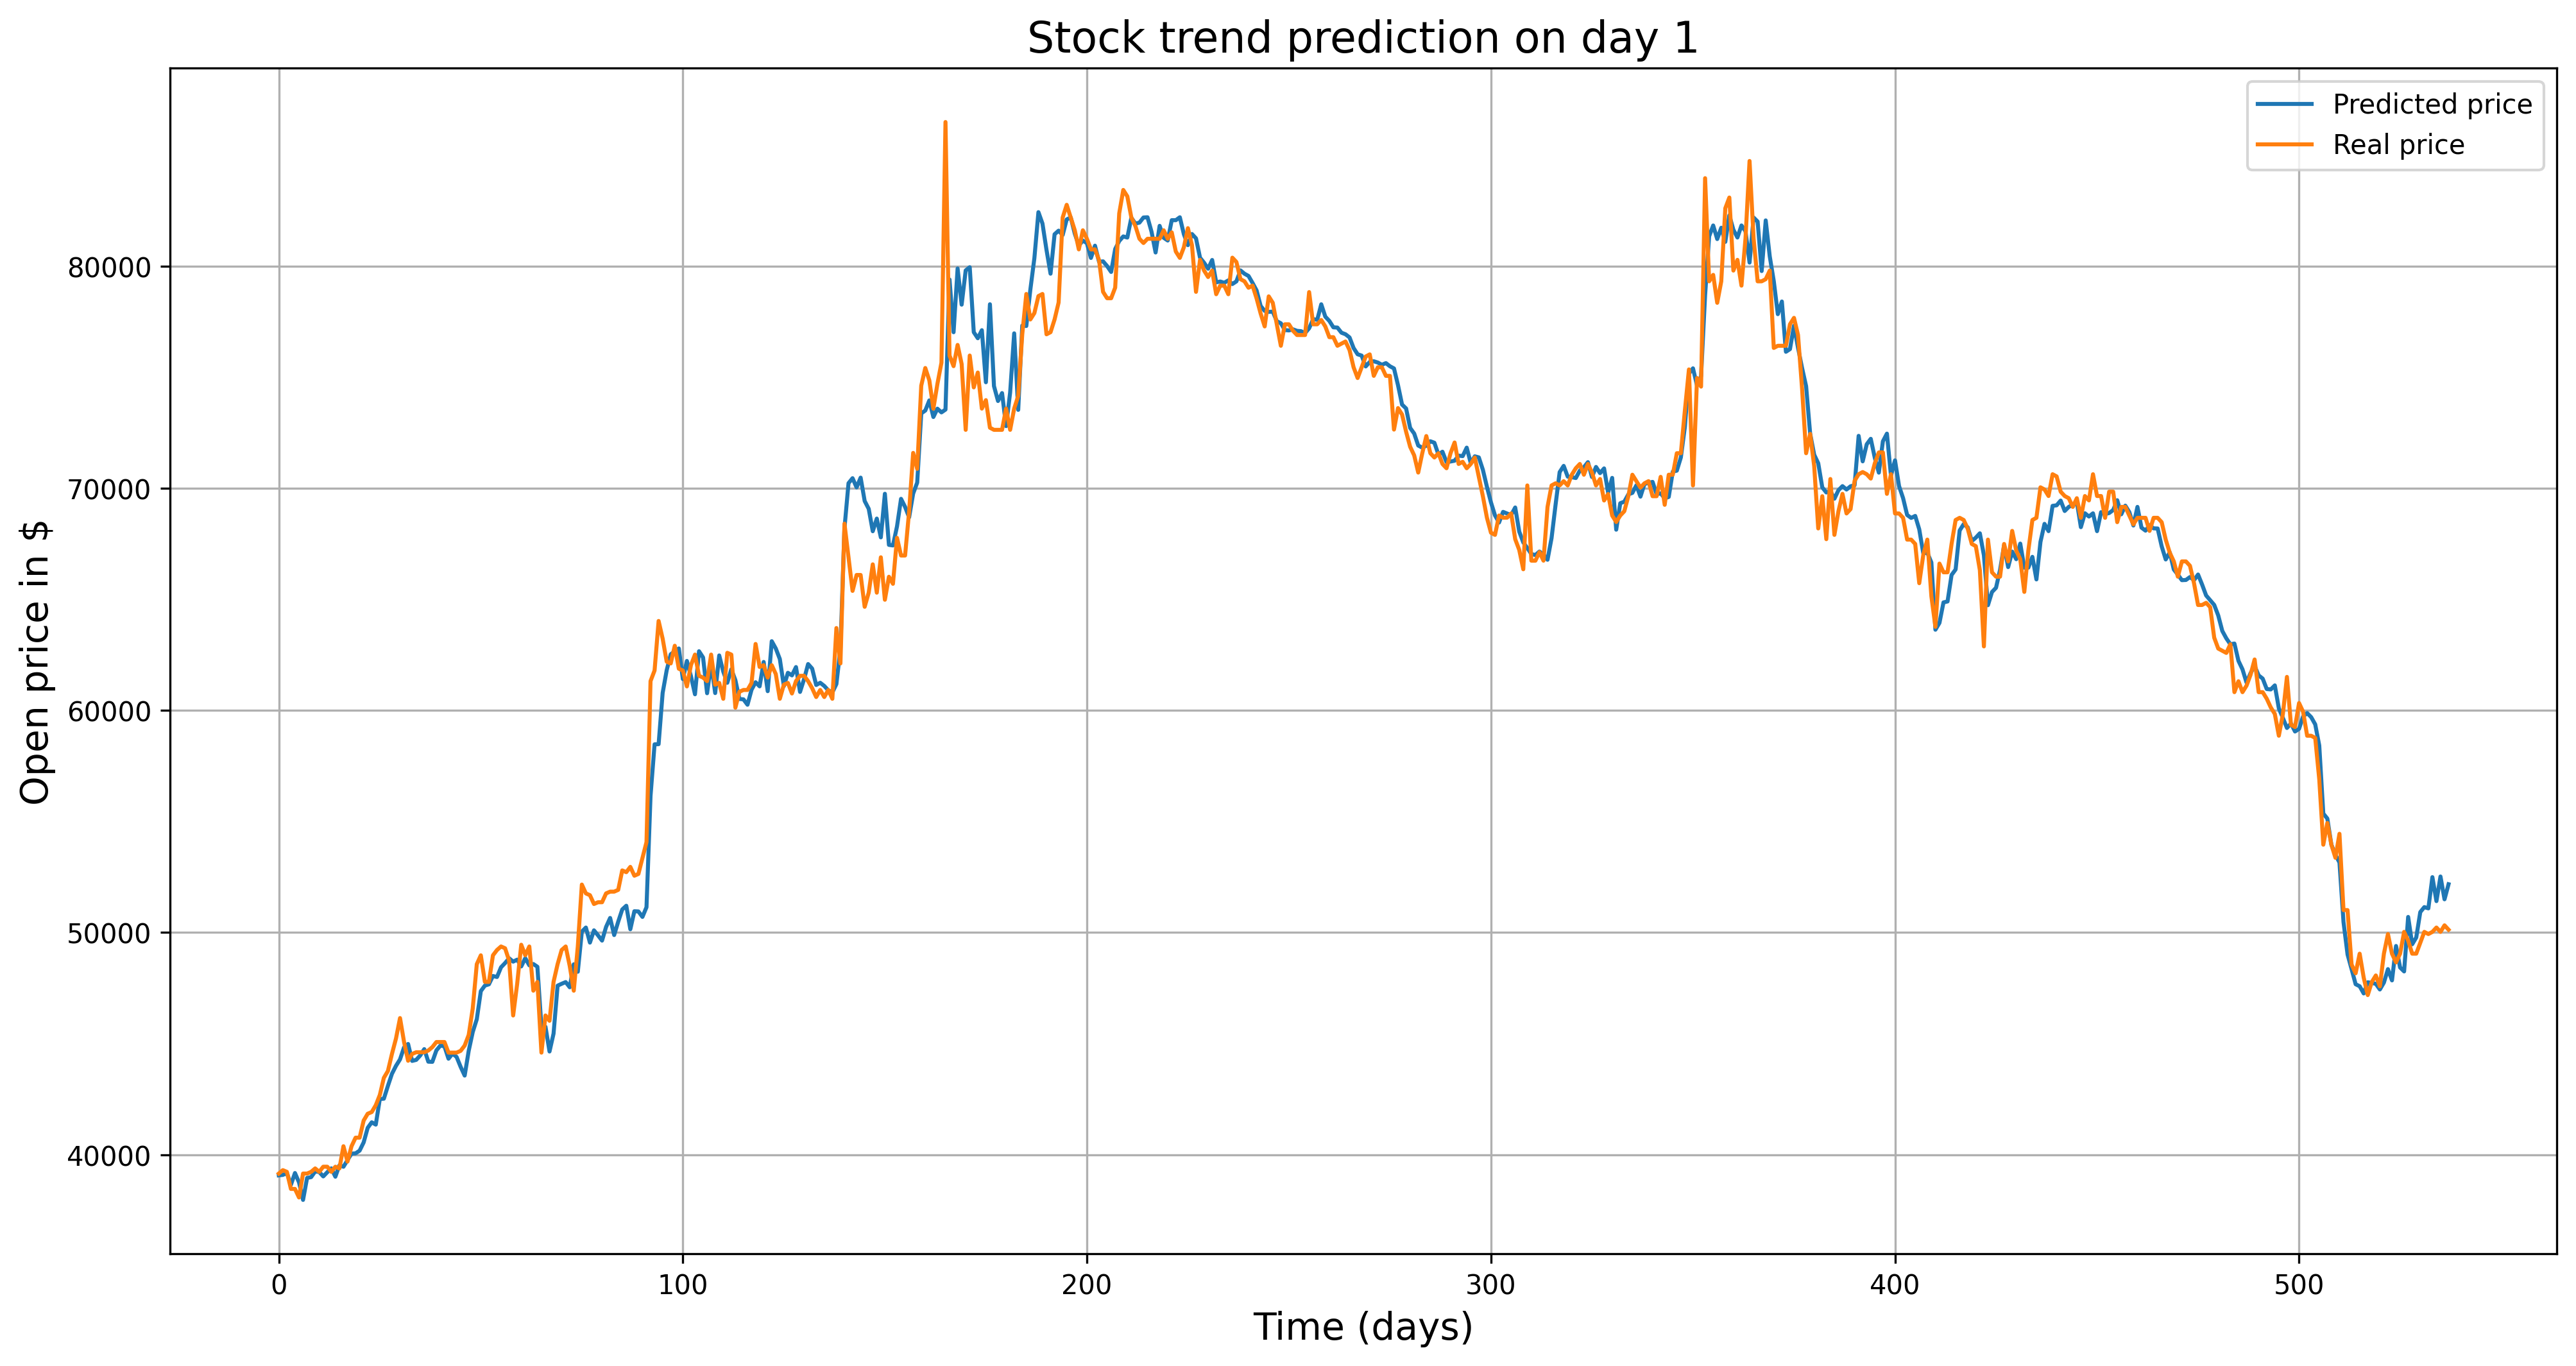

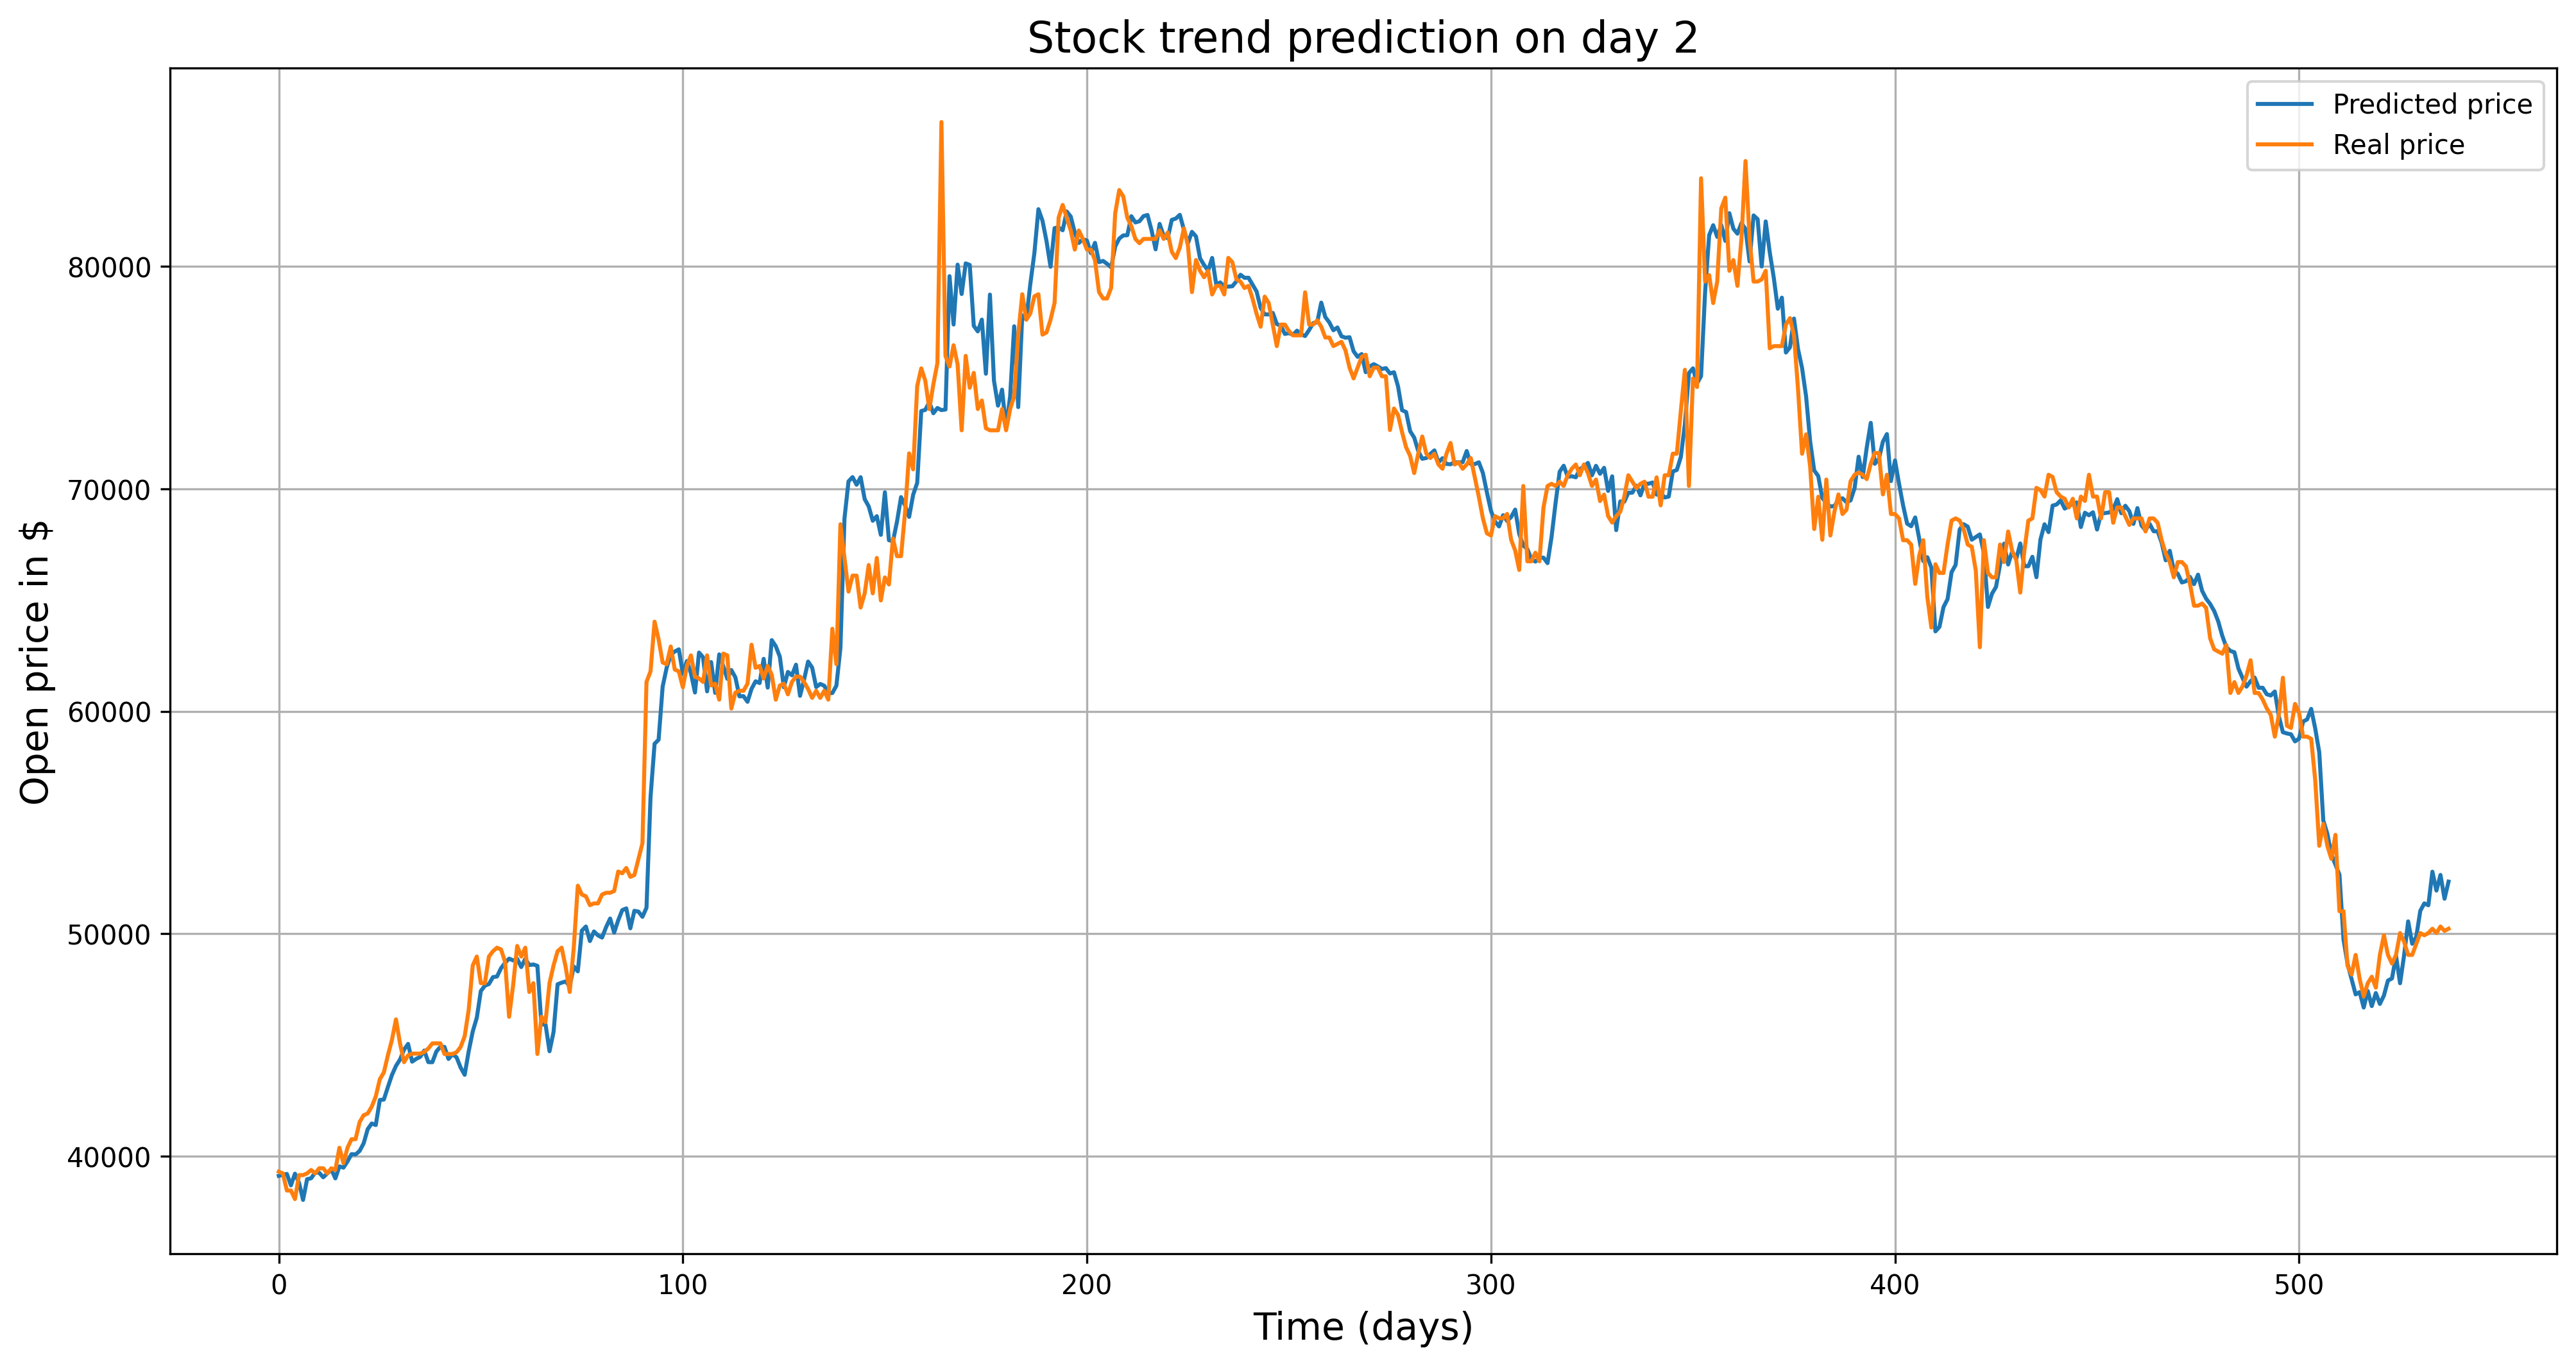

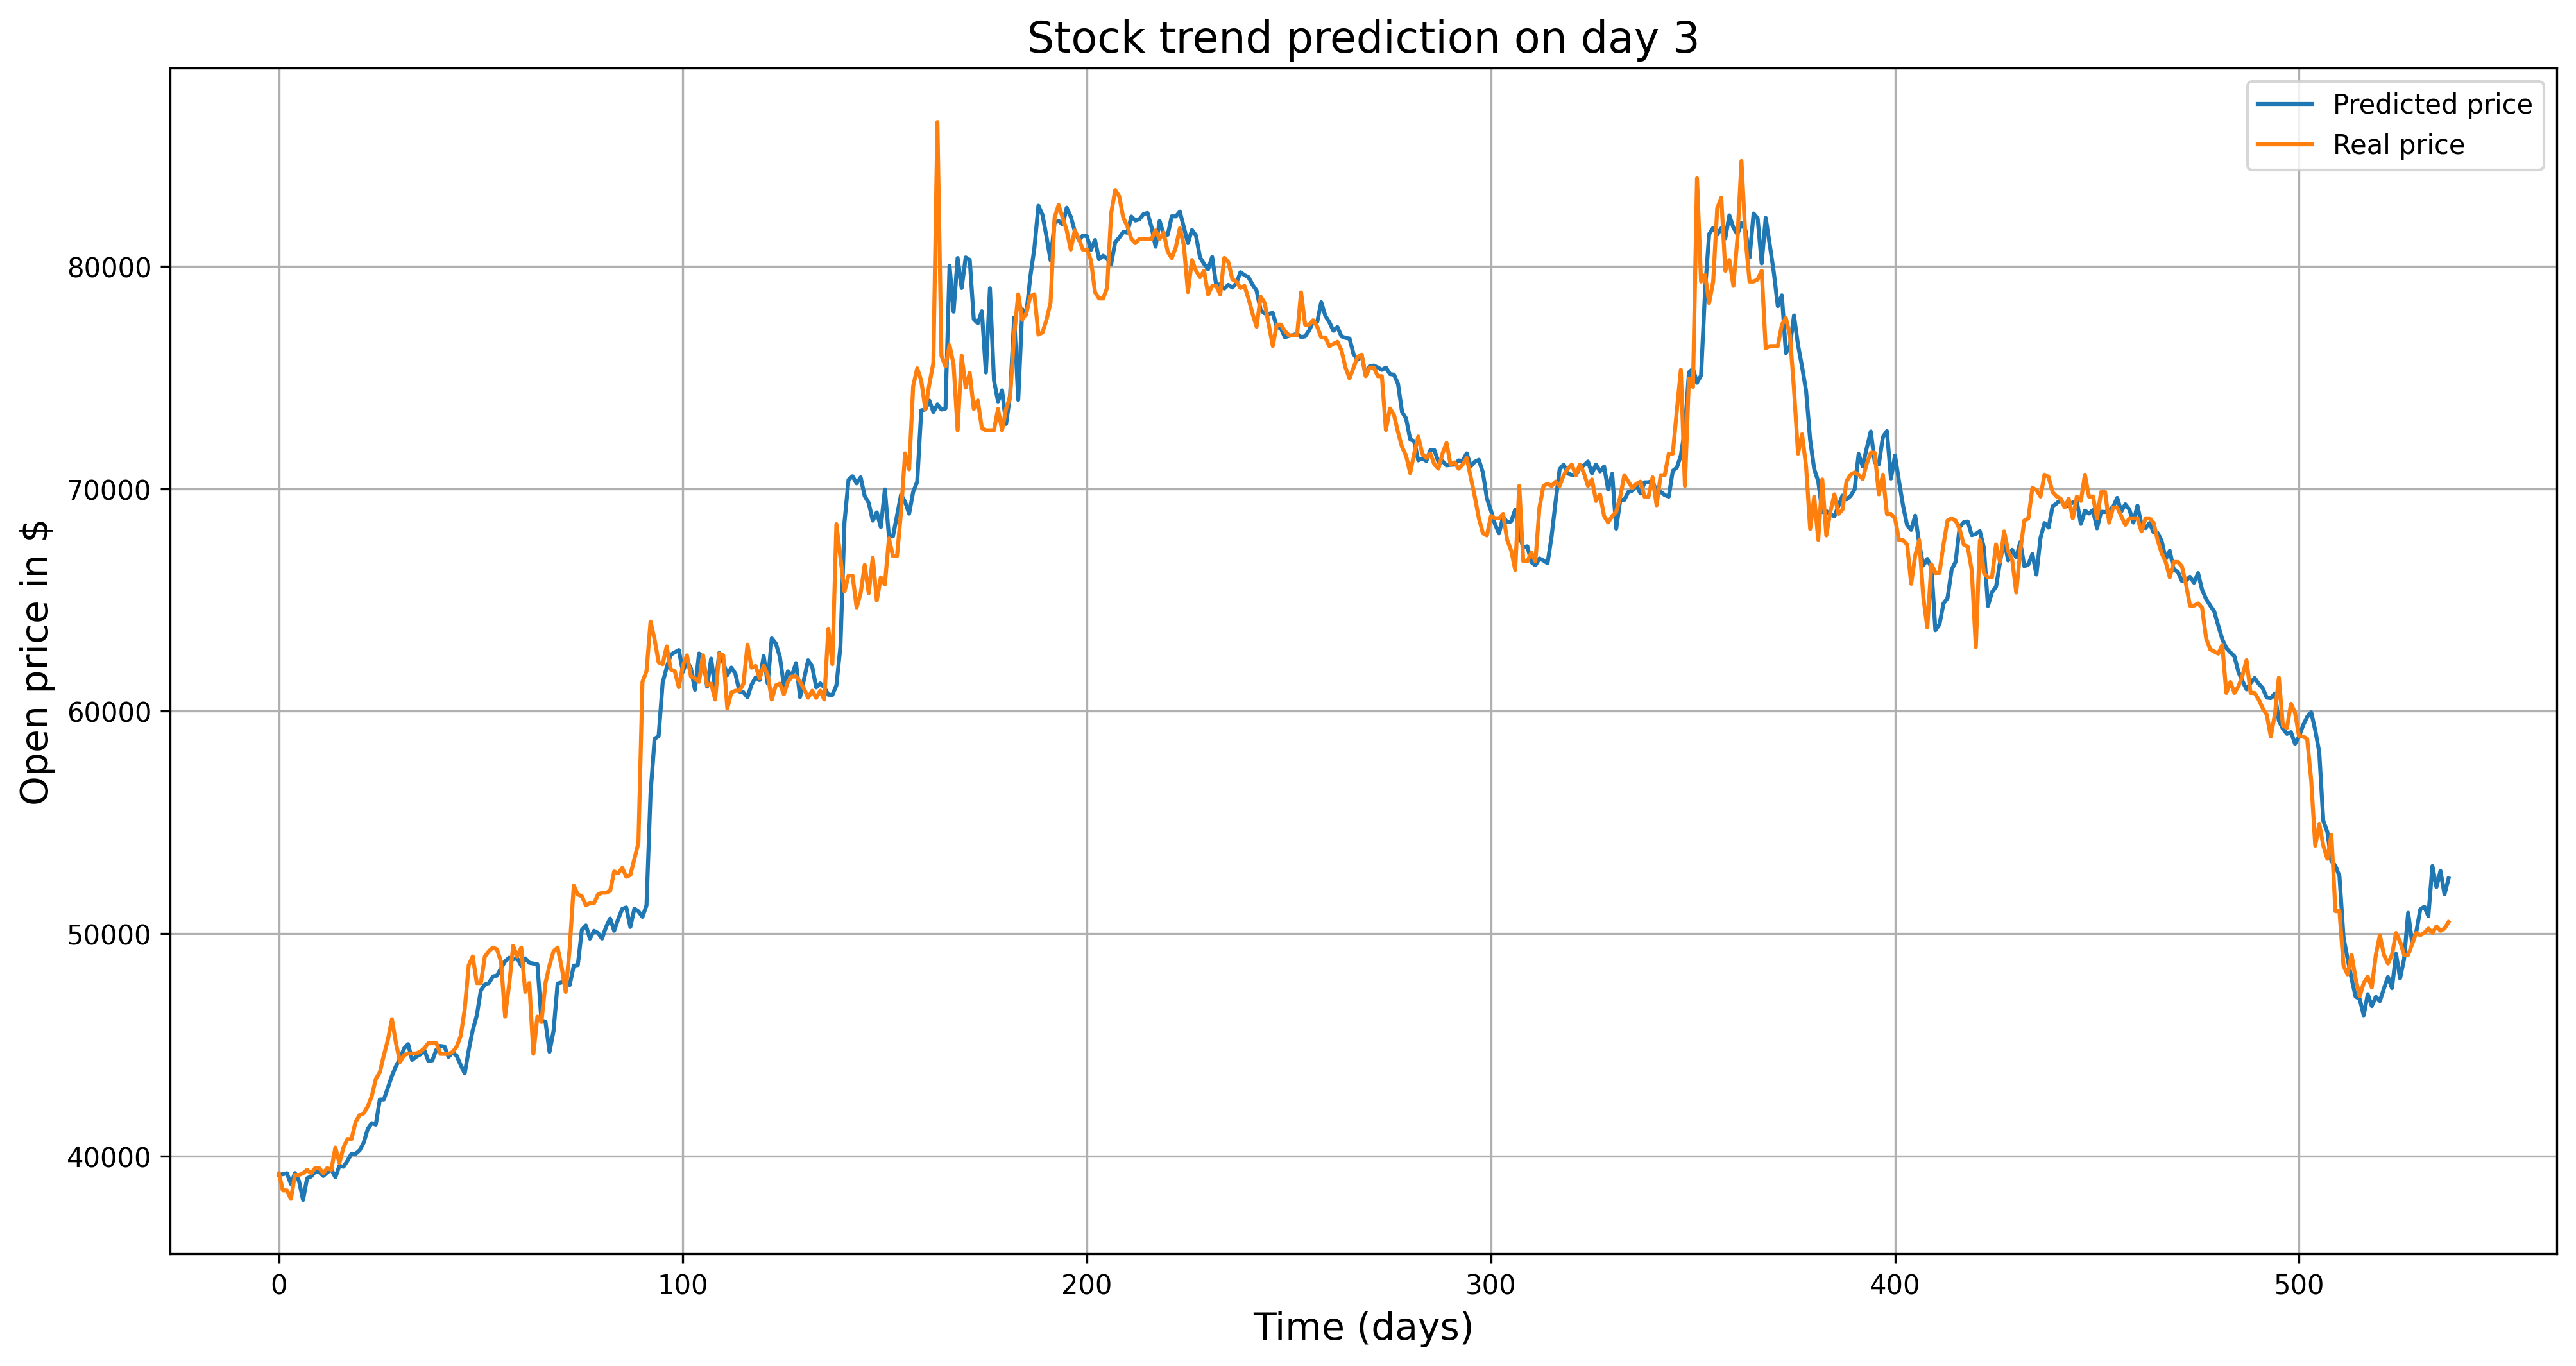

In [ ]:
# Visualize predicted stock price versus real stock price of day 1, 2, 3
plot_mulitple_days(y_pred_7_denorm, y_test_7, 1)
plot_mulitple_days(y_pred_7_denorm, y_test_7, 2)
plot_mulitple_days(y_pred_7_denorm, y_test_7, 3)

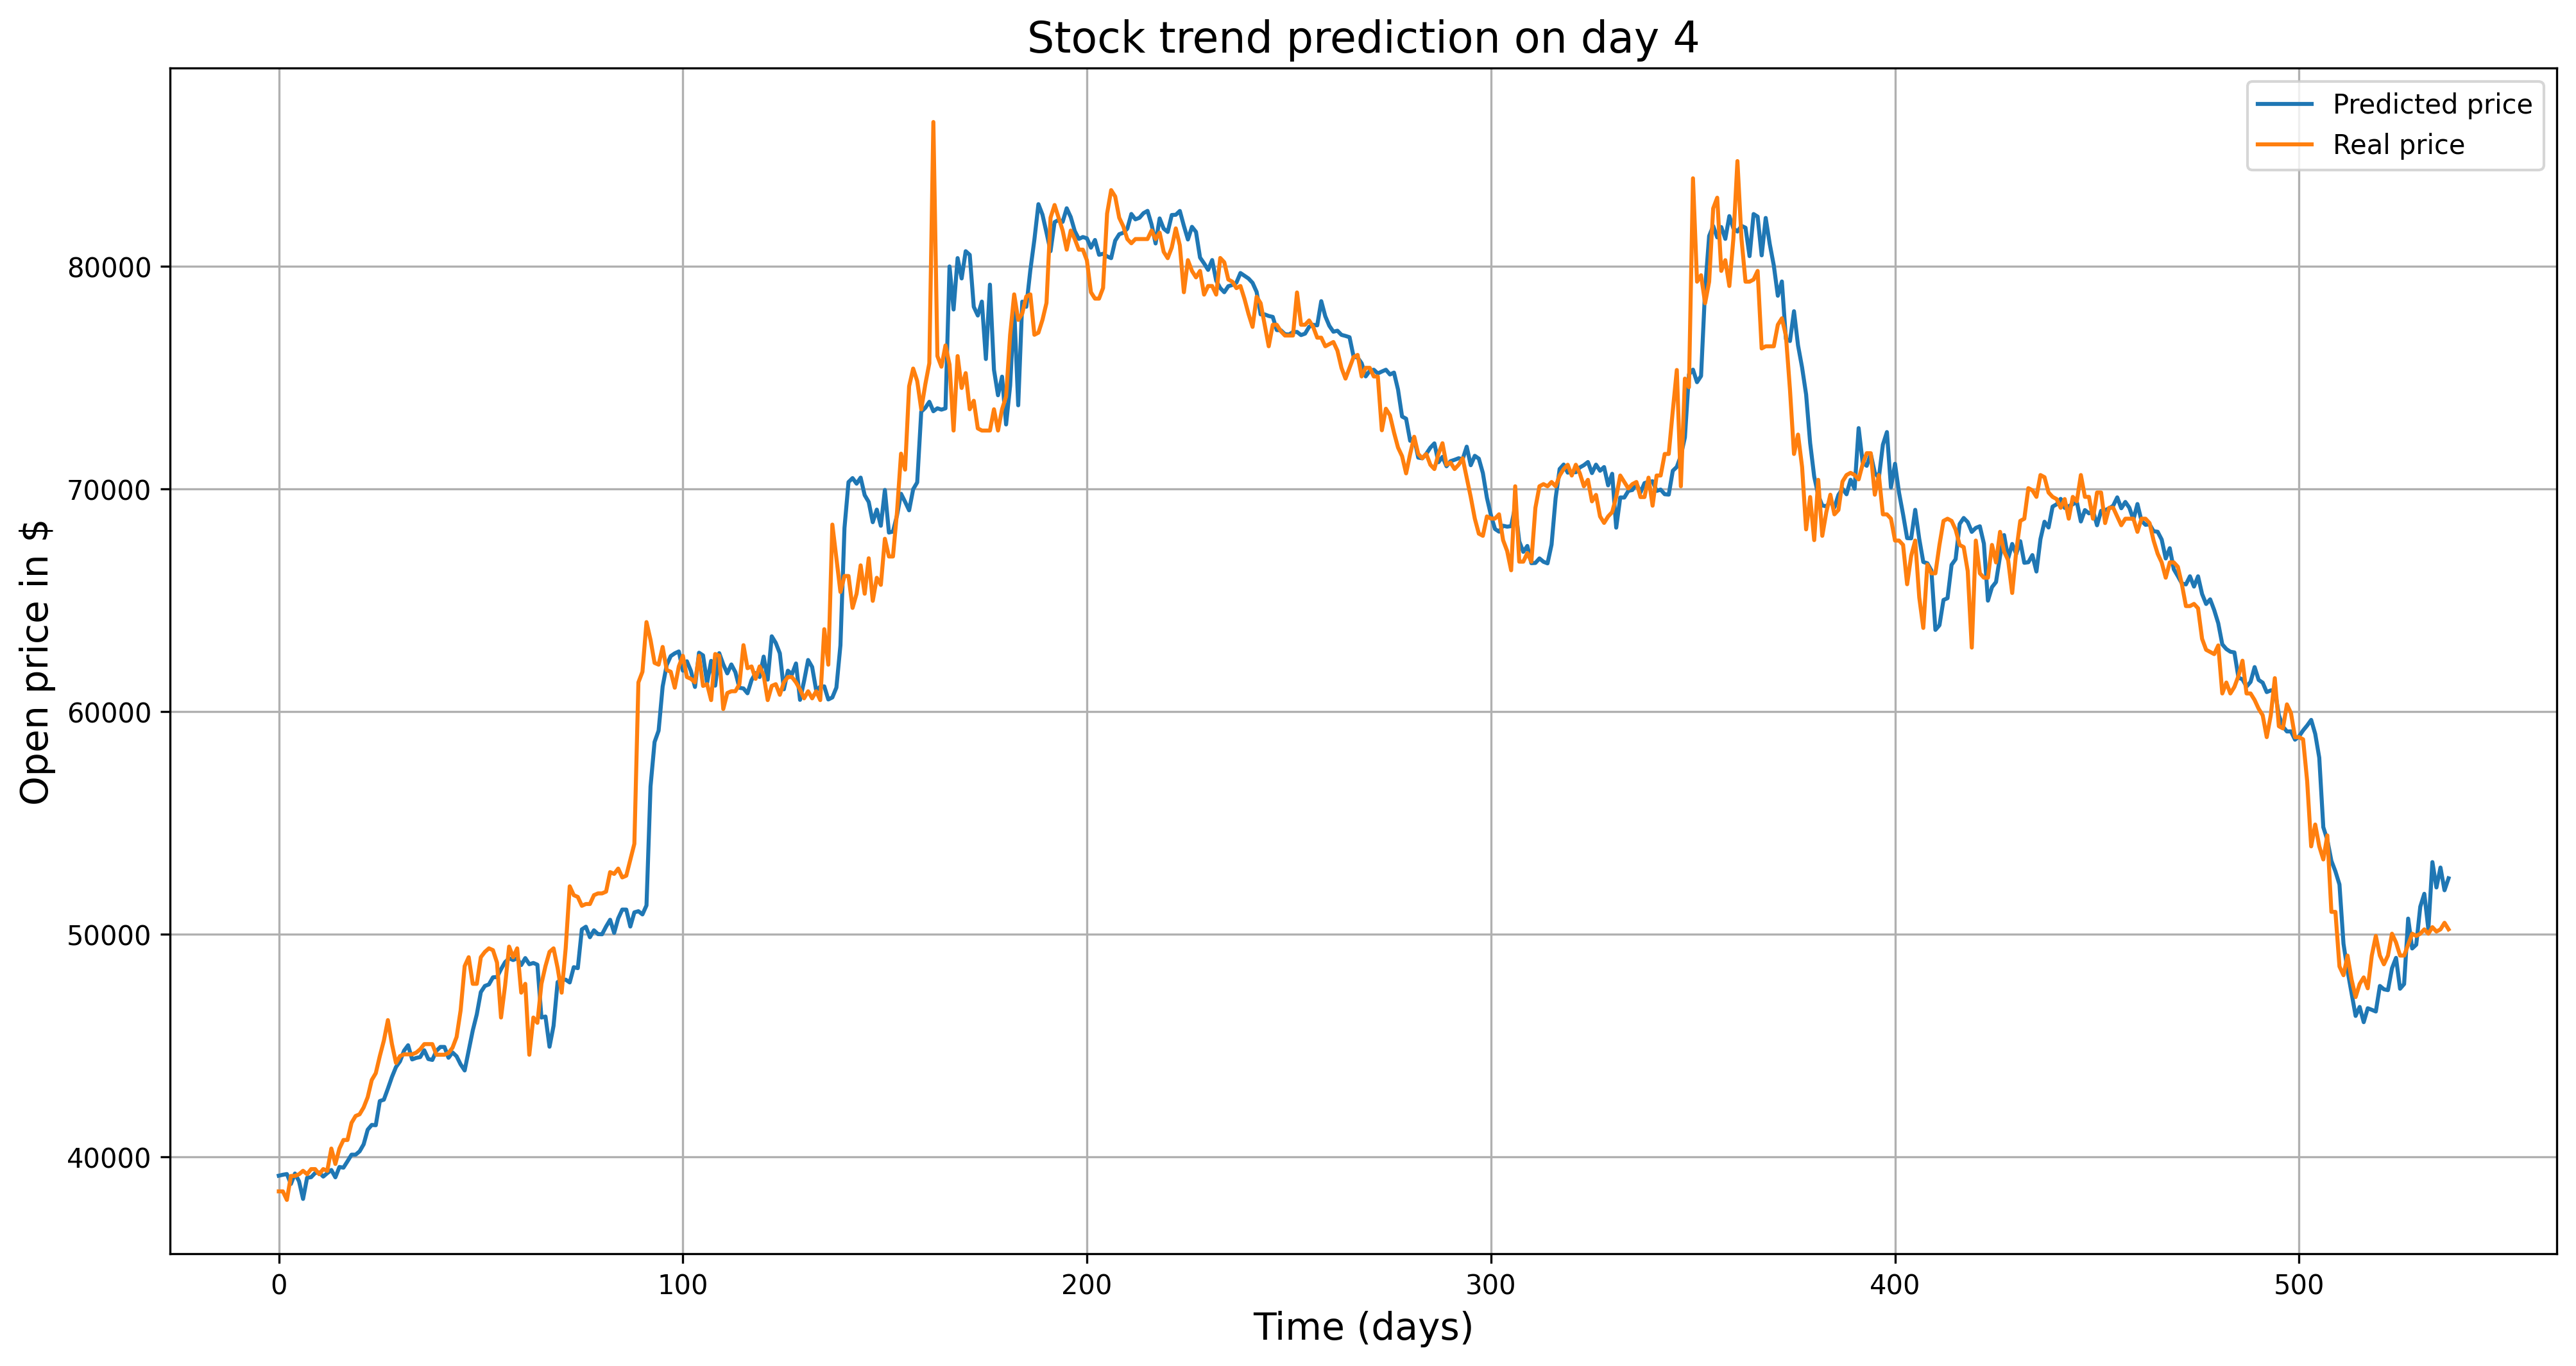

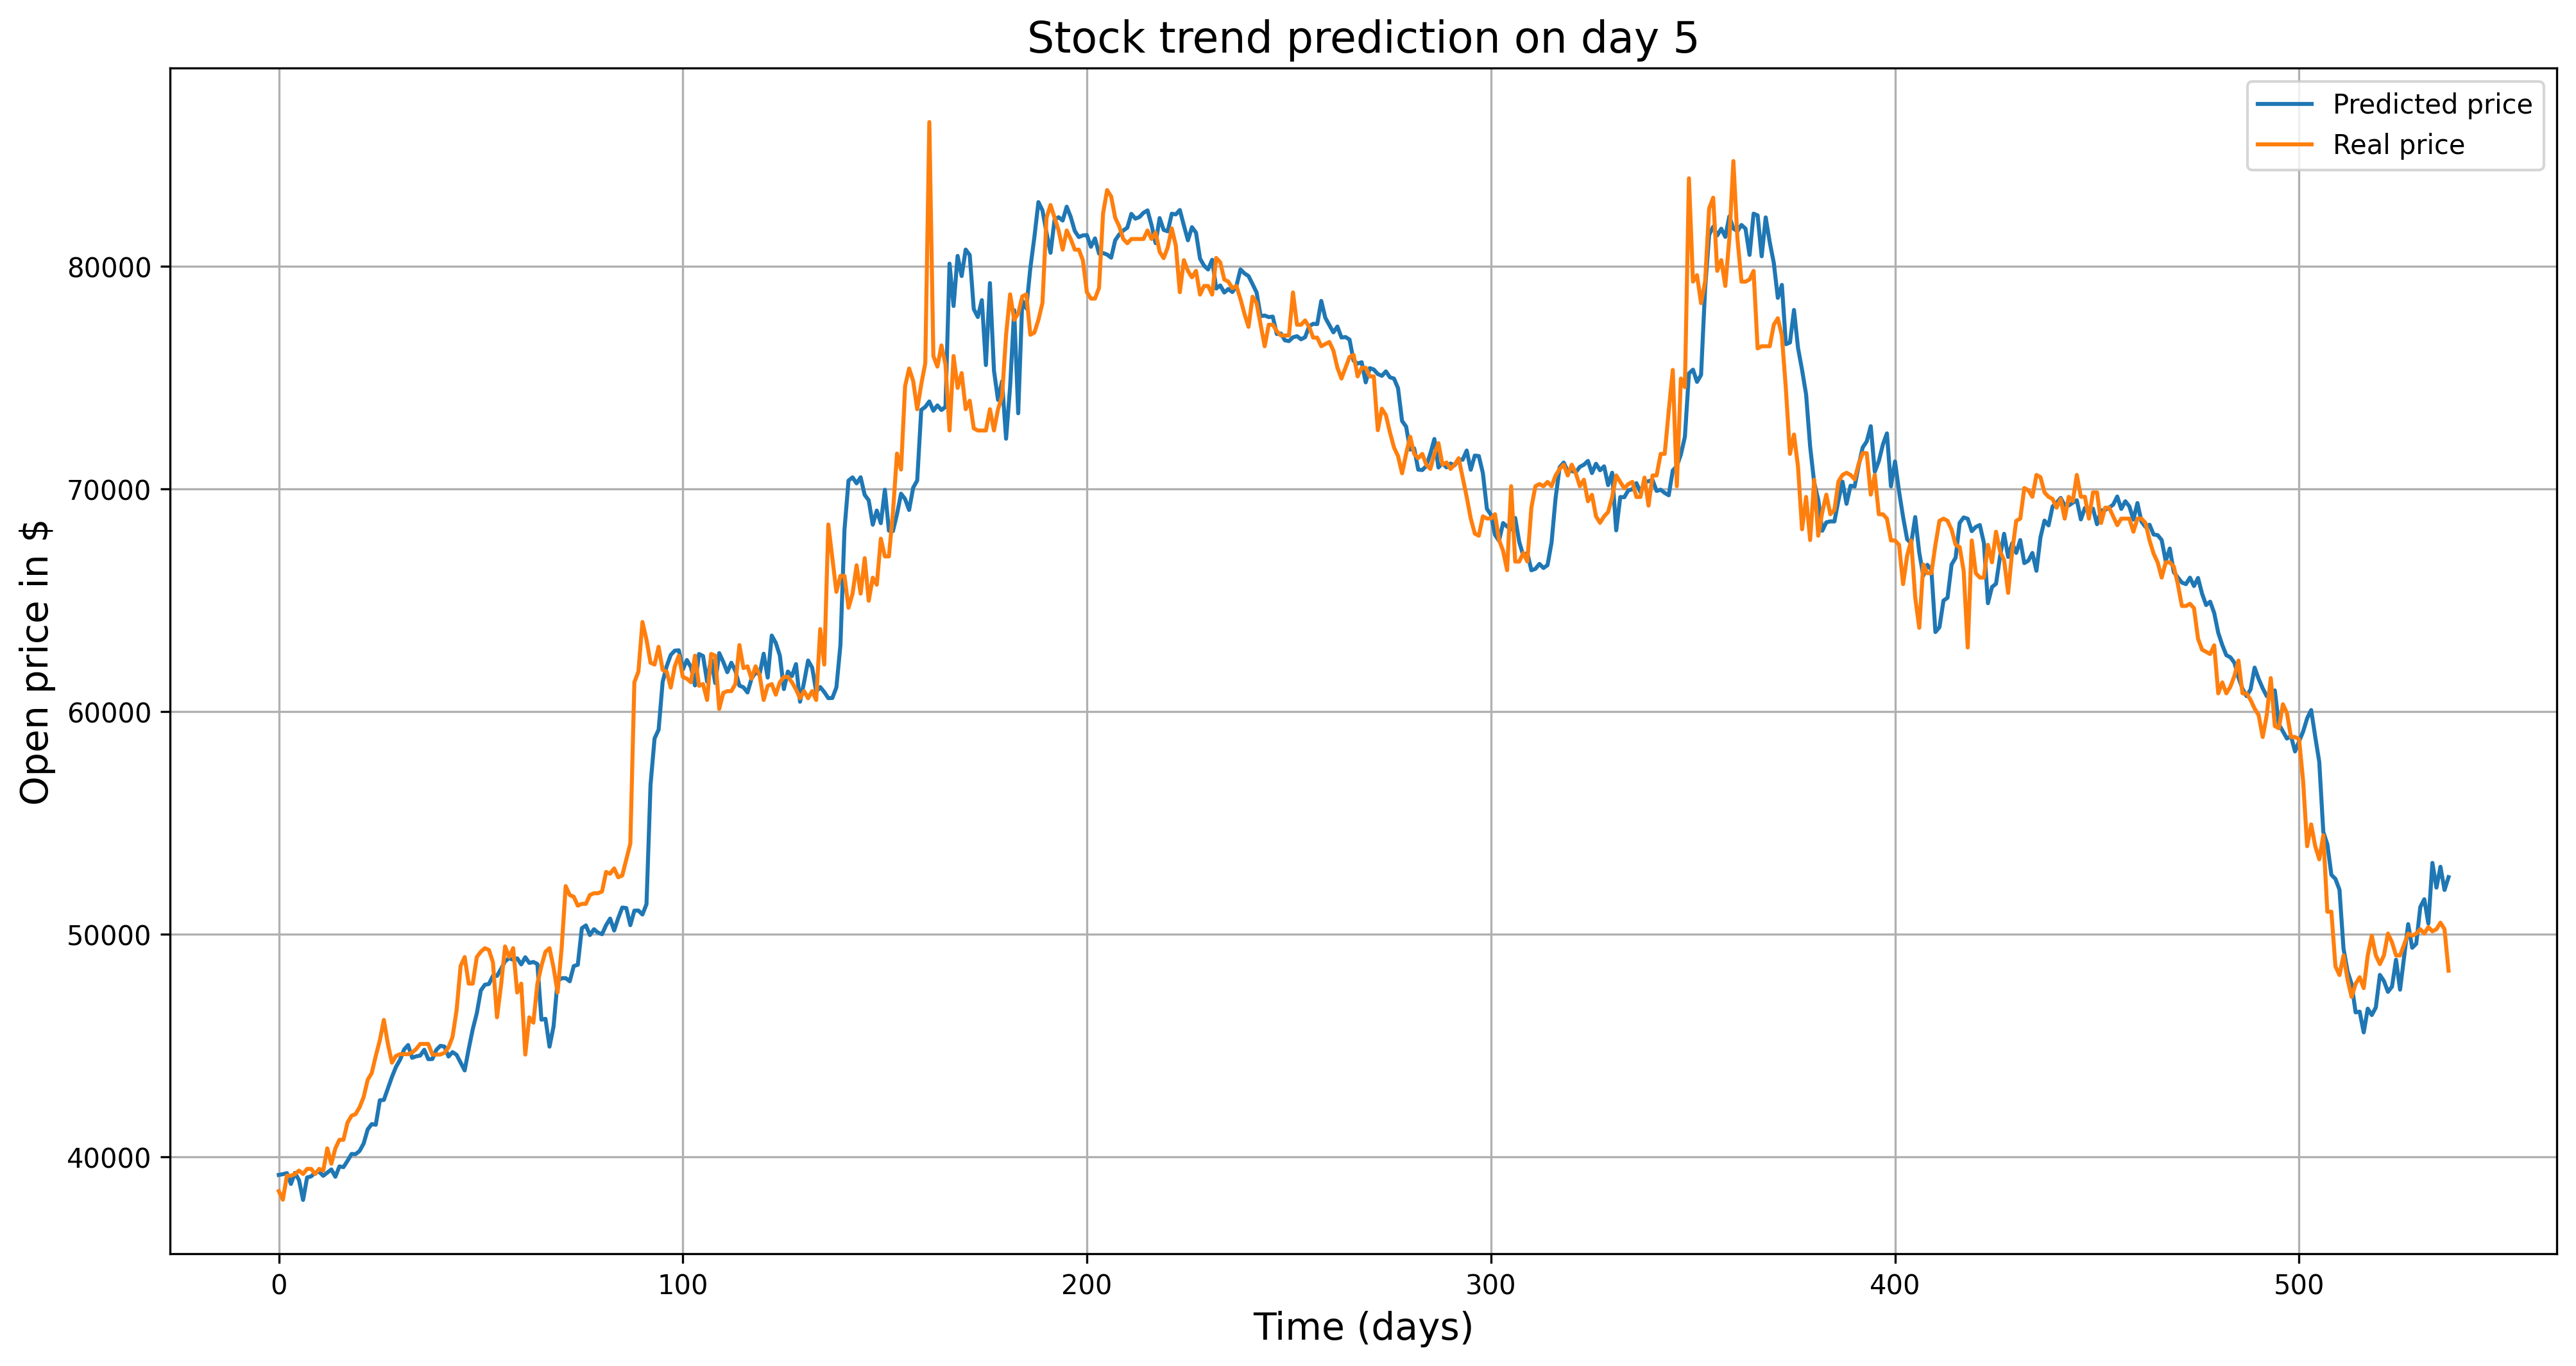

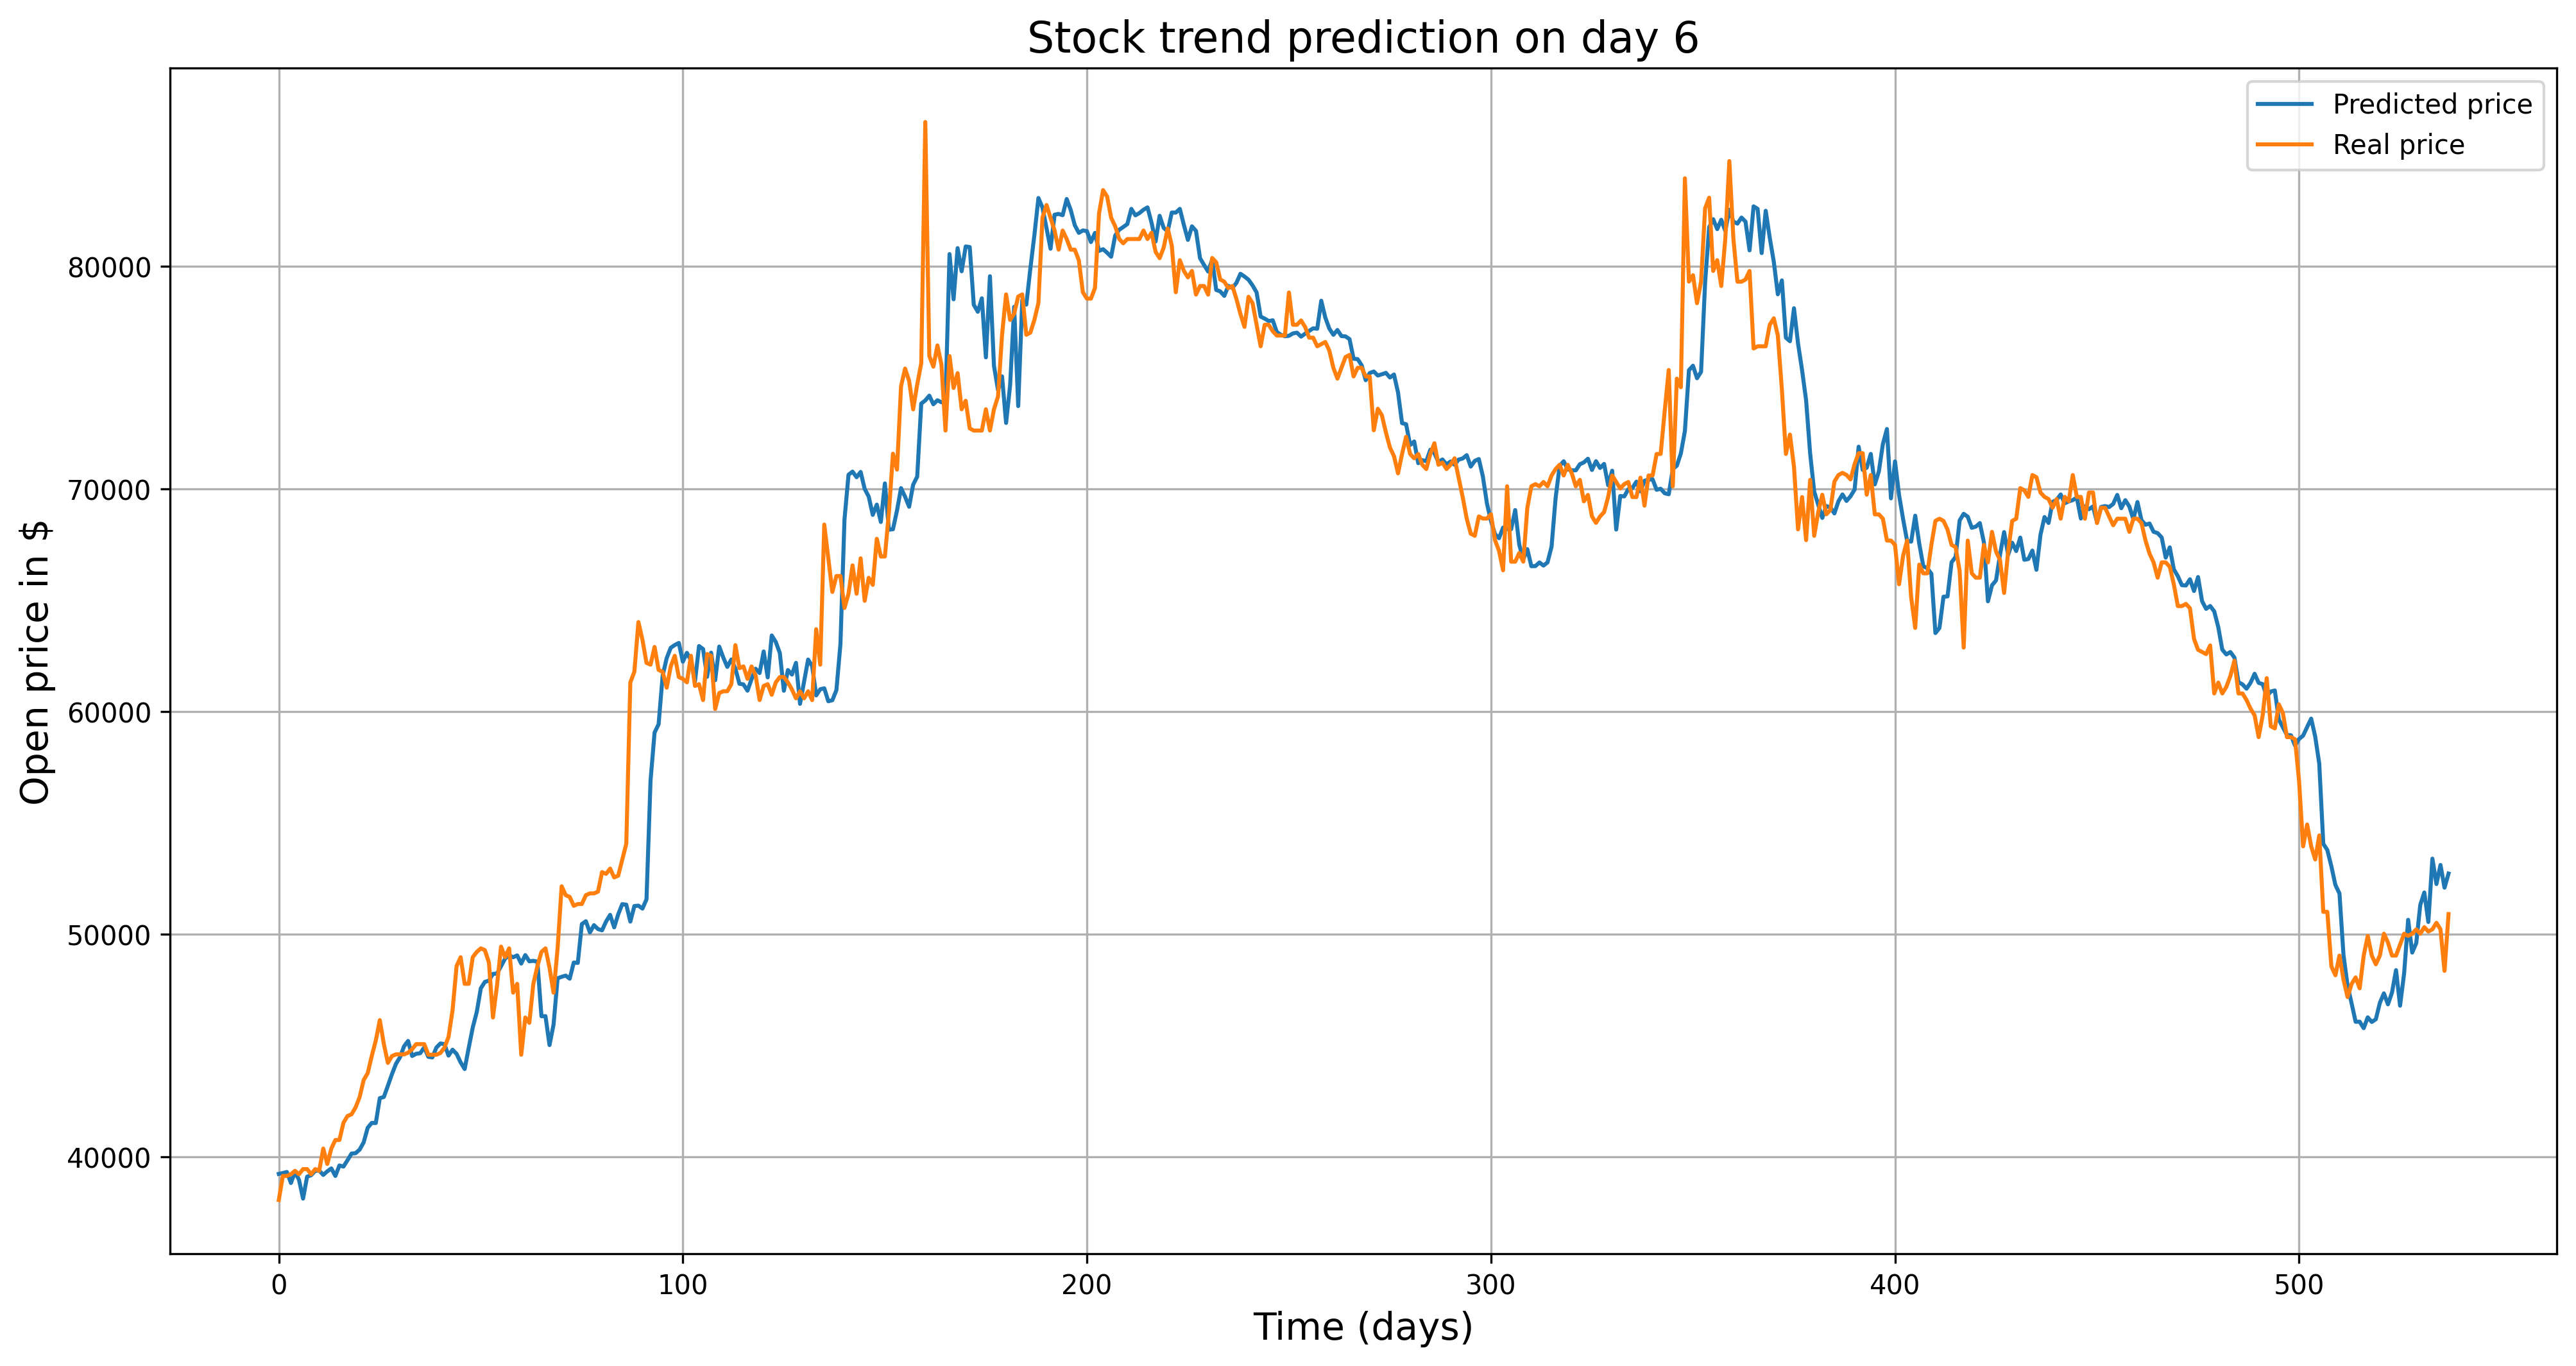

In [ ]:
# Visualize predicted stock price versus real stock price of day 4, 5, 6
plot_mulitple_days(y_pred_7_denorm, y_test_7, 4)
plot_mulitple_days(y_pred_7_denorm, y_test_7, 5)
plot_mulitple_days(y_pred_7_denorm, y_test_7, 6)

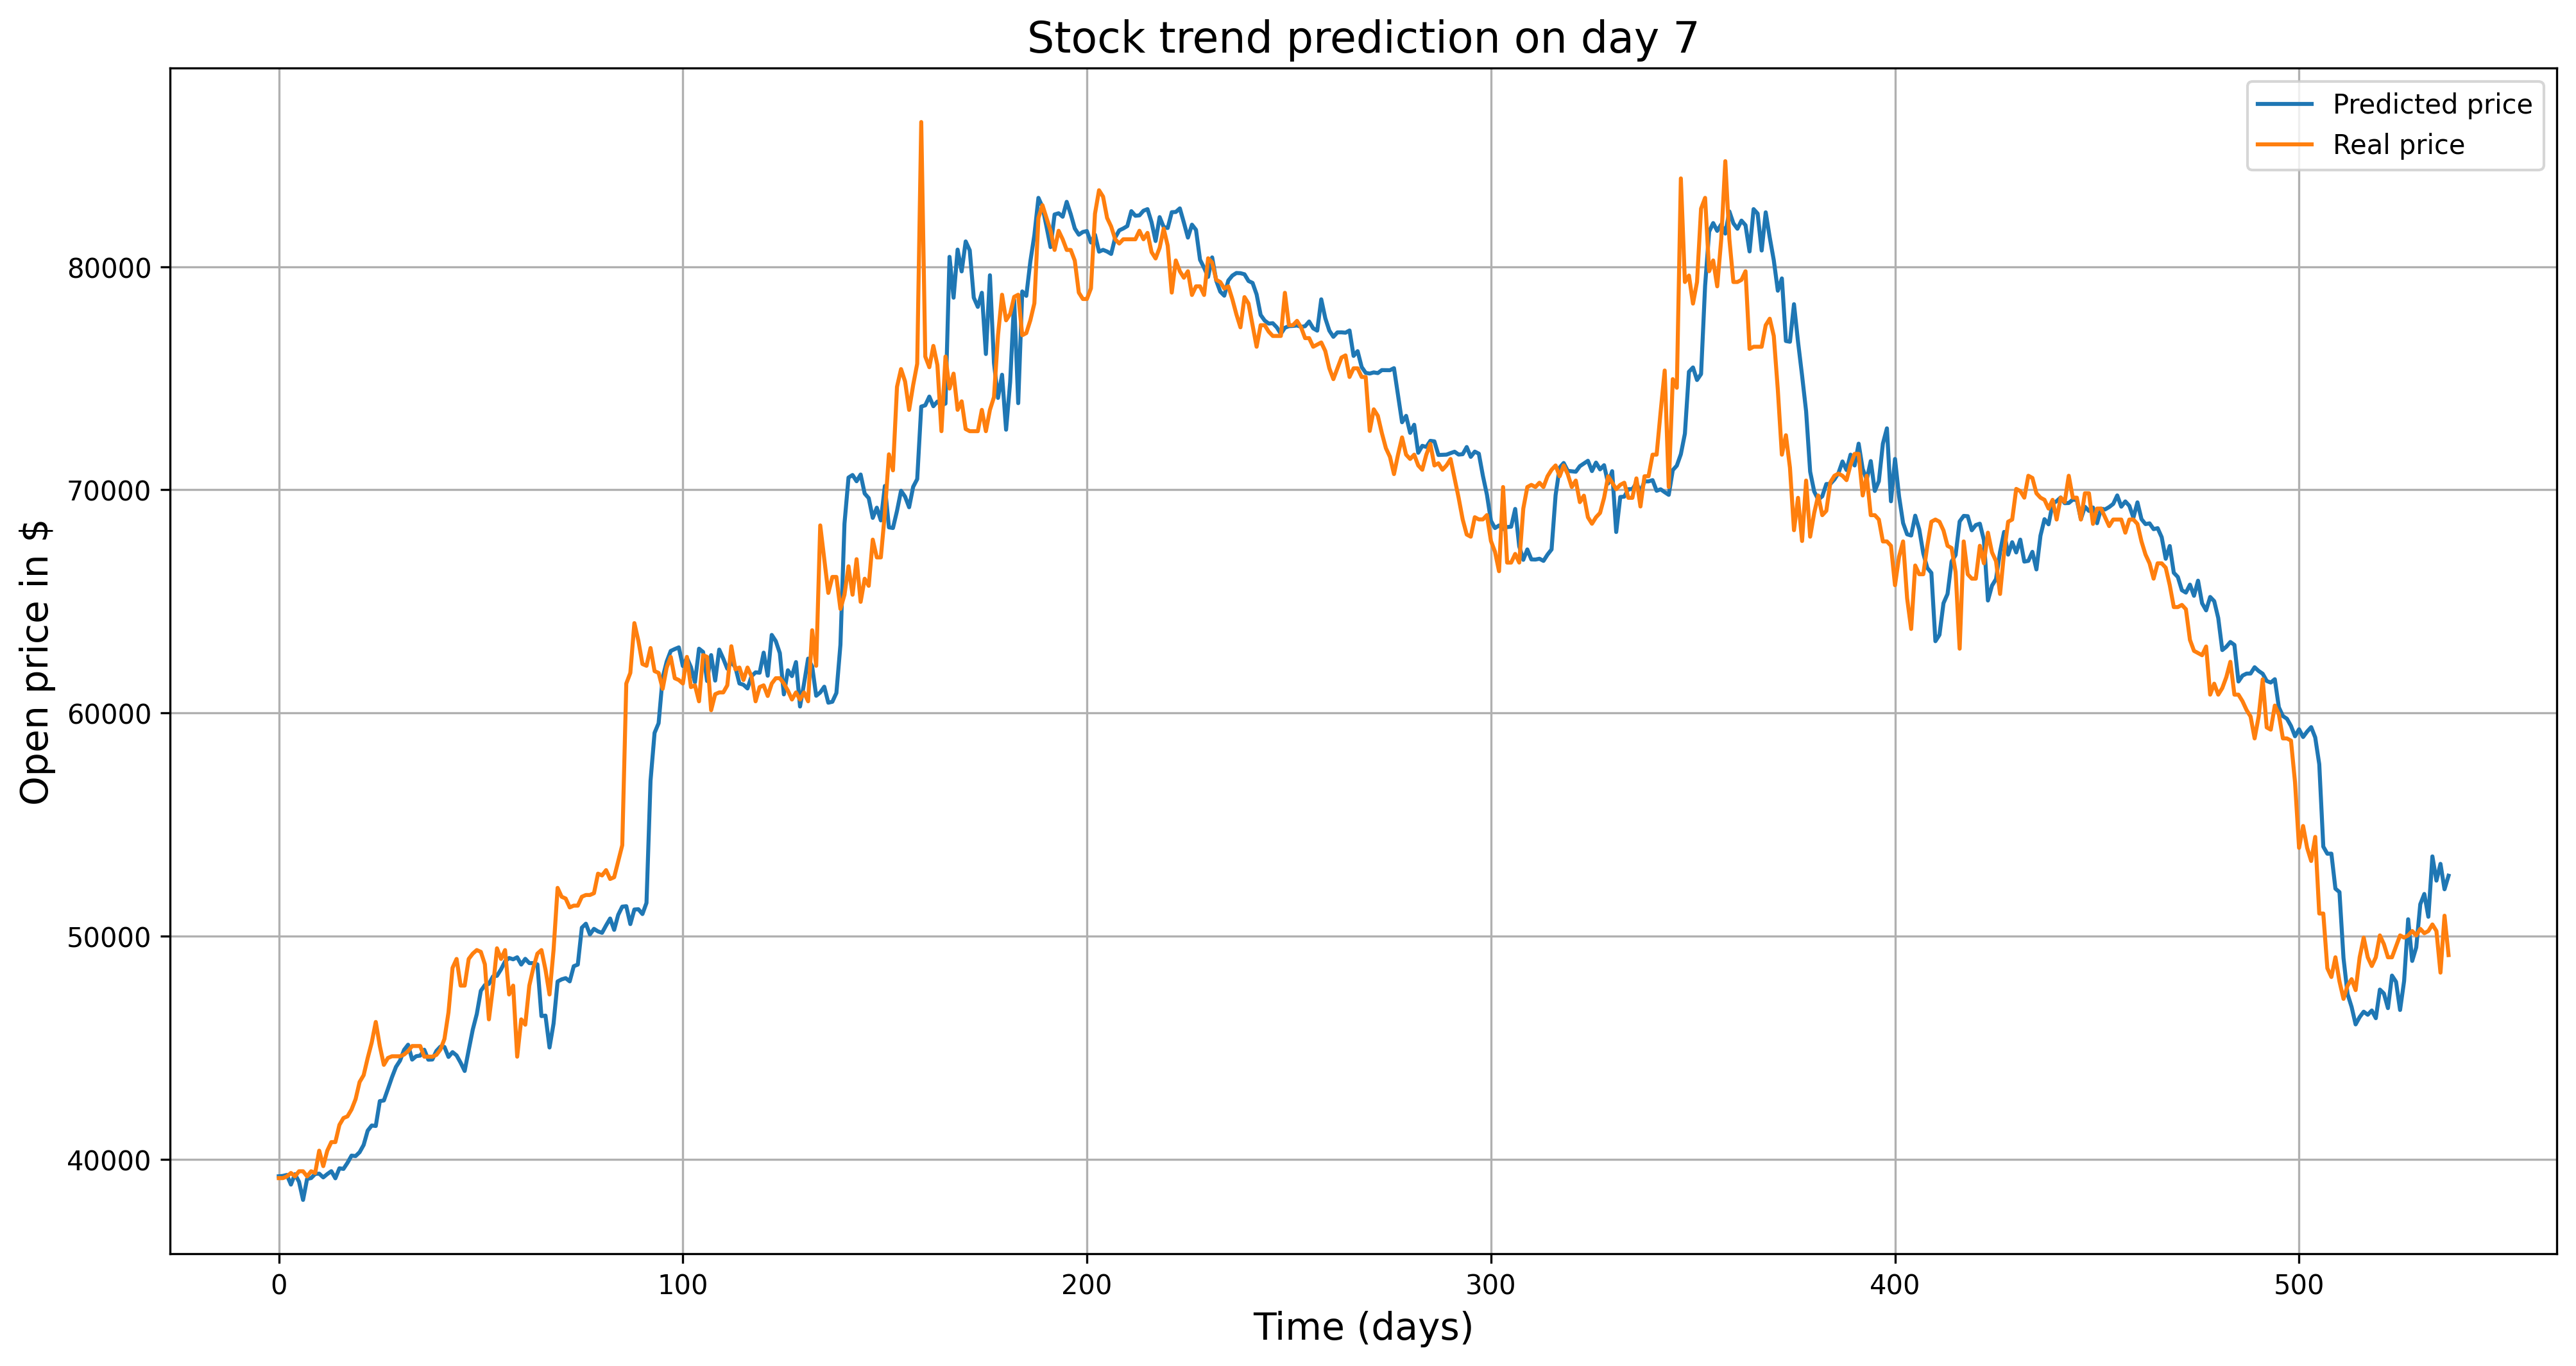

In [ ]:
# Visualize predicted stock price versus real stock price of day 7
plot_mulitple_days(y_pred_7_denorm, y_test_7, 7)

## **Trading signal identification for Vietnam market**

In [132]:
fox = load_data('FOX-UpcomIndex-History', 'data-vn/historical data')
vgi = load_data('VGI-UpcomIndex-History', 'data-vn/historical data')

#### **Create samples**

In [133]:
x_data_fox, y_data_fox = create_sample_signal(fox, features=[0, 1, 2, 3], threshold=0.12)
x_data_vgi, y_data_vgi = create_sample_signal(vgi, features=[0, 1, 2, 3], threshold=0.12)

x_data_all = [x_data_fox, x_data_vgi]
y_data_all = [y_data_fox, y_data_vgi]

In [134]:
x_data = []
y_data = []

for i in range (len(x_data_all)):
  x_data.extend(x_data_all[i])
  y_data.extend(y_data_all[i])

In [135]:
np.unique(y_data, return_counts=True)

(array([0, 1, 2]), array([   8,    8, 1788]))

#### **Training preparation**

In [136]:
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
x_train = np.array(x_train, dtype=np.float32)
x_val = np.array(x_val, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Reshape the numpy array to fit the neural network input shape requirement
window_size = 30
x_train = x_train.reshape(x_train.shape[0], window_size, 4)
x_val = x_val.reshape(x_val.shape[0], window_size, 4)
x_test = x_test.reshape(x_test.shape[0], window_size, 4)

# Print shape of the training, validation and test set
print("Shape of training set: ", x_train.shape)
print("Shape of validation set: ", x_val.shape)
print("Shape of test set: ", x_test.shape)

Shape of training set:  (1009, 30, 4)
Shape of validation set:  (253, 30, 4)
Shape of test set:  (542, 30, 4)


In [137]:
# MinMax normalize the training data
x_train_norm = x_train.copy()

for i in range(0, len(x_train)):
    min_feature = np.min(x_train[i])
    max_feature = np.max(x_train[i])
    x_train_norm[i] = (x_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data
x_val_norm = x_val.copy()

for i in range(0, len(x_val)):
    min_feature = np.min(x_val[i])
    max_feature = np.max(x_val[i])
    x_val_norm[i] = (x_val[i] - min_feature) / (max_feature - min_feature)

In [138]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [139]:
# Stopping condition
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### **Training**

In [140]:
# Build the model architecture
buy_sell_hold_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'same',input_shape=(window_size, 4)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

buy_sell_hold_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 30, 128)             │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 30, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 15, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 15, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 15, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 15, 32)              │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 7, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 7, 64)               │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 3, 1000)             │          65,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3, 500)              │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 3, 3)                │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 748,155 (2.85 MB)

 Trainable params: 747,771 (2.85 MB)

 Non-trainable params: 384 (1.50 KB)

In [141]:
buy_sell_hold_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
                            loss= tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

history = buy_sell_hold_model.fit(x_train_norm, y_train, validation_data=(x_val_norm, y_val),
                            epochs=50, batch_size=256, callbacks = [early_stopping])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4922 - loss: 0.9279 - val_accuracy: 0.6706 - val_loss: 1.0317
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7727 - loss: 0.4581 - val_accuracy: 0.6667 - val_loss: 0.9519
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9155 - loss: 0.2322 - val_accuracy: 0.9947 - val_loss: 0.9226
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9685 - loss: 0.1012 - val_accuracy: 0.7536 - val_loss: 0.8421
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9898 - loss: 0.0531 - val_accuracy: 0.7984 - val_loss: 0.7577
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9925 - loss: 0.0516 - val_accuracy: 0.9249 - val_loss: 0.6937
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9939 - loss: 0.0399 - val_accuracy: 0.9947 - val_loss: 0.6360
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9948 - loss: 0.0418 - val_accuracy: 0.9947 - val_loss: 0.6165
E

In [142]:
x_test_norm = x_test.copy()

for i in range(0, len(x_test)):
    min_feature = np.min(x_test[i])
    max_feature = np.max(x_test[i])
    x_test_norm[i] = (x_test[i] - min_feature) / (max_feature - min_feature)

In [143]:
result = buy_sell_hold_model.evaluate(x_test_norm, y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9937 - loss: 0.3683


## **Portfolio**

In [202]:
fox = load_data('FOX-UpcomIndex-History', 'data-vn/historical data')
vgi = load_data('VGI-UpcomIndex-History', 'data-vn/historical data')
abc = load_data('ABC-UpcomIndex-History', 'data-vn/historical data')
mfs = load_data('MFS-UpcomIndex-History', 'data-vn/historical data')
pai = load_data('PAI-UpcomIndex-History', 'data-vn/historical data')
pia = load_data('PIA-HNXIndex-History', 'data-vn/historical data')
ptp = load_data('PTP-UpcomIndex-History', 'data-vn/historical data')
ttn = load_data('TTN-UpcomIndex-History', 'data-vn/historical data')

In [203]:
fox = set_day_index(fox)
vgi = set_day_index(vgi)
abc = set_day_index(abc)
mfs = set_day_index(mfs)
pai = set_day_index(pai)
pia = set_day_index(pia)
ptp = set_day_index(ptp)
ttn = set_day_index(ttn)

In [222]:
fox_chart = create_combined_chart(fox, 'FOX')
fox_chart.show()

In [252]:
abc_chart = create_combined_chart(abc, 'ABC')
abc_chart.update_yaxes(range=[0, 900000], secondary_y=True)
abc_chart.show()

In [250]:
vgi_chart = create_combined_chart(vgi, 'VGI')
vgi_chart.update_yaxes(range=[0, 20000000], secondary_y=True)
vgi_chart.show()

In [249]:
pai_chart = create_combined_chart(pai, 'PAI')
pai_chart.update_yaxes(range=[0, 1000], secondary_y=True)
pai_chart.show()

In [247]:
pia_chart = create_combined_chart(pia, 'PIA')
pia_chart.update_yaxes(range=[0, 200000], secondary_y=True)
pia_chart.show()

In [234]:
mfs_chart = create_combined_chart(mfs, 'MFS')
mfs_chart.update_yaxes(range=[0, 2000000], secondary_y=True)
mfs_chart.show()

In [238]:
ttn_chart = create_combined_chart(ttn, 'TTN')
ttn_chart.update_yaxes(range=[0, 4000000], secondary_y=True)
ttn_chart.show()

In [243]:
ptp_chart = create_combined_chart(ptp, 'PTP')
ptp_chart.update_yaxes(range=[0, 100000], secondary_y=True)
ptp_chart.show()